In [1]:
import sys
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import mdtraj as md
from scipy import stats
#from scipy.interpolate import CubicSpline


#bme_dir='/projects/prism/people/hzr104/software/BME_OLD'
#sys.path.append(bme_dir)
#import BME as BME

blocking_dir='/projects/prism/people/hzr104/software/BLOCKING_OLD/MonoCV'
sys.path.append(blocking_dir)
import block

#import itertools
#import os

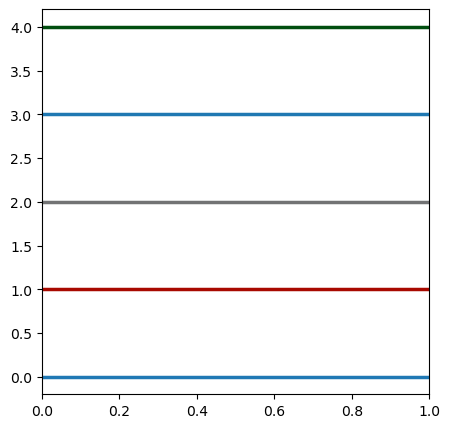

In [2]:
from matplotlib.colors import LinearSegmentedColormap

#new_cmap = ['#1b9e77', '#d95f02', '#7570b3', '#1f78b4', '#ca0020']
new_cmap= ['#1f78b4', '#A80900', '#737373', '#1f78b4', '#004e0f'] 
rtg_r = LinearSegmentedColormap.from_list("rtg", new_cmap)
colors = rtg_r(np.linspace(0,1,5))

#Test colormap
fig = plt.figure(figsize=(5,5))

for i,color in enumerate(colors):
    plt.axhline(i, color=colors[i], linewidth=2.5)

In [3]:
traj = '../trajectory_CG/prodrun_joinedreplicas.xtc'
top = '../trajectory_CG/PRO_CG.gro'
priortype = 'weighted'

errmethod = 'hline' #for blocking
contacts_cutoff = 0.8

DBD_atoms = np.arange(325, 504) #138GLU-209ARG (inclusive)
LBD_atoms = np.arange(556, 1187) #234PRO-505TYR (inclusive)

AB_resis = np.arange(0, 137)
DBD_hinge_LBD_resis = np.arange(137, 505)
DBD_resis = np.arange(137, 205)
LBD_resis = np.arange(234, 505)


In [4]:
#Loads SAXS intensities calculated from simulations - in BME format
def load_sim_SAXS(calc_file):
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(calc_file) if("#" not in line)])
    return np.array(calc_data)

#Loads experimental SAXS q, I and err - in BME format
def load_exp_SAXS(exp_file):
    q, I, err = np.genfromtxt(exp_file, usecols=(0,1,2), skip_header=0, unpack=True)
    return np.array(q), np.array(I), np.array(err)

def get_chi2(Iaverage_sim, I_exp, err_exp):
    
    chi2 = np.average(np.square((Iaverage_sim-I_exp)/err_exp))
    
    return chi2

#Fit calc data profiles scale and offset with linear regression
def fit_scale_offset(Iaverage_sim, I_exp, err_exp):
    #Get weight for each point based on exp error
    sample_weight=1.0/(err_exp**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=True).fit(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    slope,intercept = reg.coef_[0],reg.intercept_
    
    Iaverage_sim_fit = Iaverage_sim*slope+intercept
    
    return Iaverage_sim_fit, slope, intercept, r_value

#Fit calc data scale with linear regression
def fit_scale(obs_calc, obs_exp, obs_exp_err):
    #Get weight for each point based on exp error
    sample_weight=1.0/(obs_exp_err**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=False).fit(obs_calc.reshape(-1,1),obs_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(obs_calc.reshape(-1,1),obs_exp.reshape(-1,1),sample_weight=sample_weight)
    slope = reg.coef_[0]
    
    obs_calc_fit = obs_calc*slope
    
    return obs_calc_fit, slope, r_value

def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

def block_err_analysis(CV, errmethod):
    ##Block error anaylsis
    
    #Trim Rg array for block error analysis
    CV = block.check(CV, multi=1)

    #Block error analysis
    blocks_stat = block.blocking(CV)

    #Choose optimal block size and find error
    if errmethod=='b3':
        corr_len, err = block.optimal_block(len(CV),blocks_stat,method="b3")
    elif errmethod=='knee_loc':
        corr_len, err = block.optimal_block(len(CV),blocks_stat,method="knee_loc",S=2.7)
    elif errmethod=='hline':
        corr_len, err = block.optimal_block(len(CV),blocks_stat,method="hline")
        
    return corr_len, err, blocks_stat

#Make array of all resi combinations for input to mdtraj distance/contacts calcuations
def make_resi_pairs(resi_range_1, resi_range_2):
    resis_list_1 = np.concatenate([resi_range_1]*len(resi_range_2),axis=None)
    resis_list_2 = np.repeat(resi_range_2, len(resi_range_1), axis=None)
    resi_pairs = np.append(resis_list_1.reshape(-1,1), resis_list_2.reshape(-1,1), axis=1)
    
    return resi_pairs

#Function to calculate contacts for each resi in group1 to all residues in group2
#For each protein returns a list along the sequence of group1 with average nr contacts to group2
def get_seq_contacts(group1_resis, group2_resis, contacts_cutoff, traj):

    #Calculate contacts between each residue in sequence and group
    seq_contacts = []
    for resi in group1_resis:

        #Get resi pairs
        resi_pairs = make_resi_pairs([resi], group2_resis)  
        #Calculate distances
        resi_distances = md.compute_contacts(traj, contacts=resi_pairs, scheme='closest')
        #Count contacts
        resi_contacts = np.count_nonzero(resi_distances[0]<contact_cutoff, axis=1)
        #Average contacts over simulation and append to list
        seq_contacts.append(resi_contacts)

        print(f'Calculated contacts for resi {resi}')

    return np.array(seq_contacts)

def srel(w0,w1):
    idxs = np.where(w1>1.0E-50)
    return np.sum(w1[idxs]*np.log(w1[idxs]/w0[idxs]))

# Select theta and R2 weight for R2 and SAXS reweighting

In [5]:
theta_sel_R2_and_SAXS=6

R2_fmoderrrel_floats = np.arange(0.00, 0.51, 0.05)

R2_fmoderrrel = []
for R2 in R2_fmoderrrel_floats:
    R2_fmoderrrel.append(f'{R2:.2f}')

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2894491/1652106435.py:15: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi_{eff}$', fontsize=20)
/tmp/ipykernel_2894491/1652106435.py:16: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('$\chi^2_r$', fontsize=20)


0.00
1000.0
1.3964196842107852
0.05
1000.0
1.39391334554508
0.10
1000.0
1.3877502047627253
0.15
1000.0
1.3835934909431826
0.20
1000.0
1.3817440931240434
0.25
1000.0
1.379585373002749
0.30
1000.0
1.3796471807150008
0.35
1000.0
1.3803276632416948
0.40
1000.0
1.3808390923962854
0.45
1000.0
1.380659609551935
0.50
1000.0
1.3796701666275655


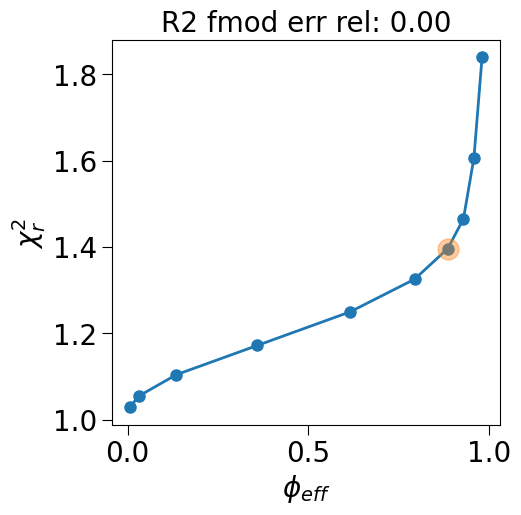

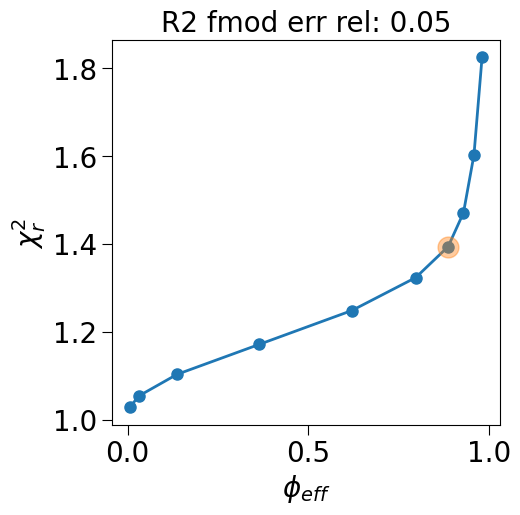

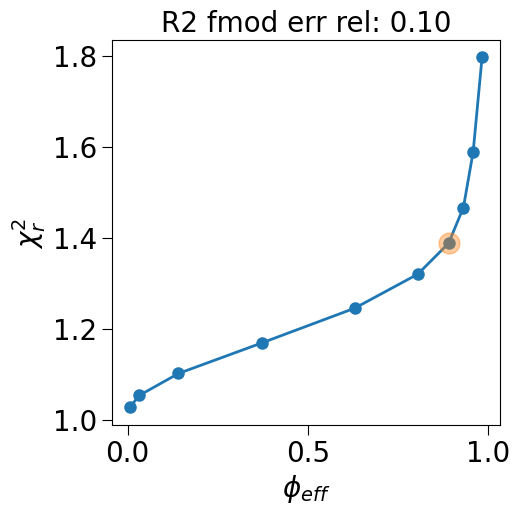

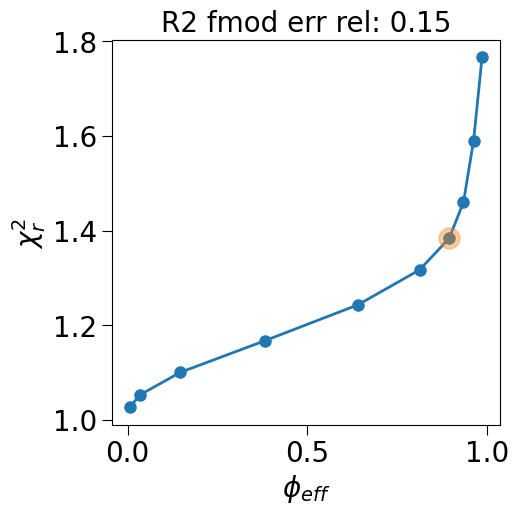

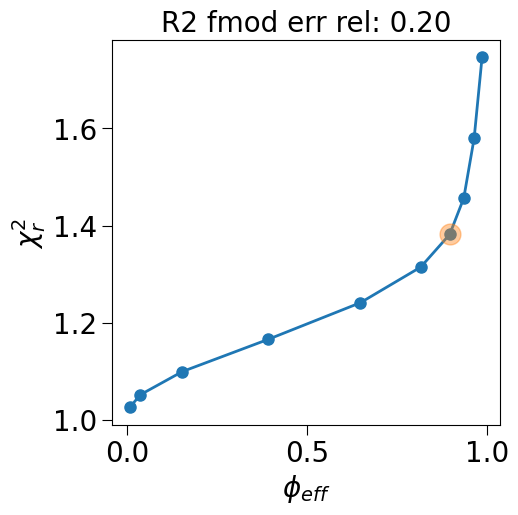

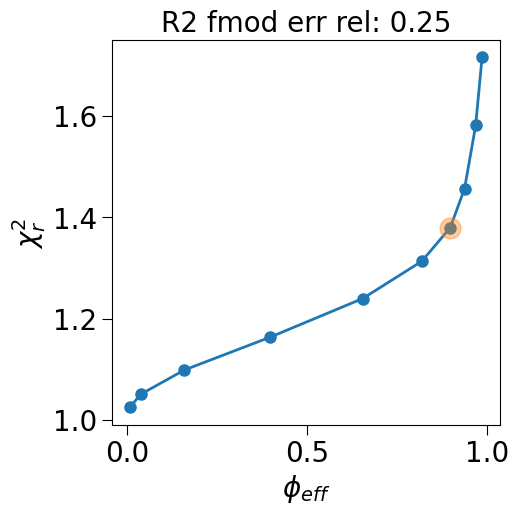

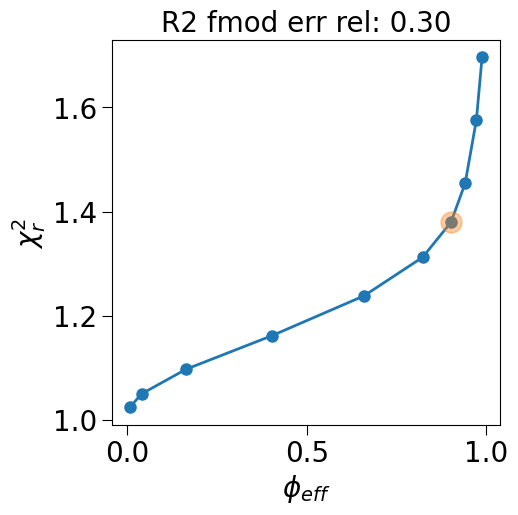

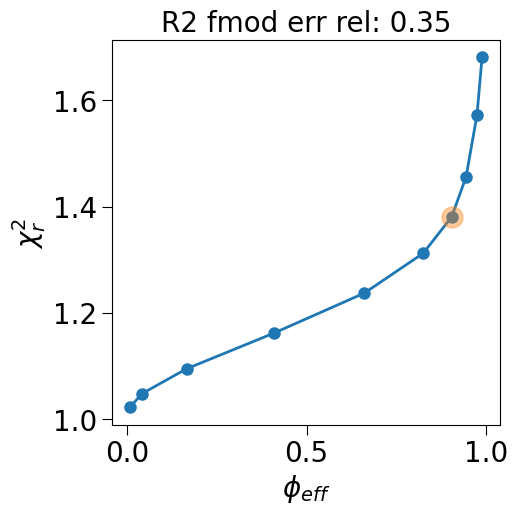

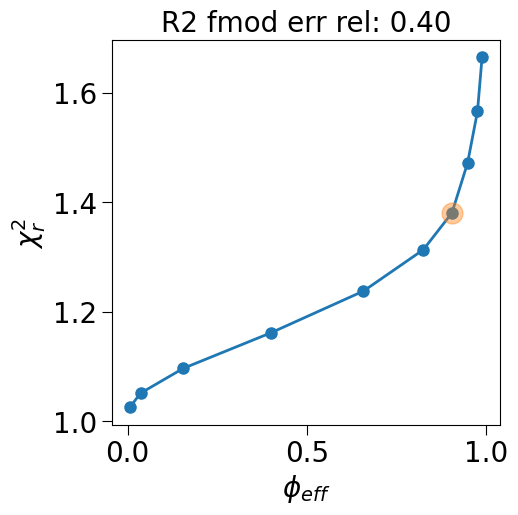

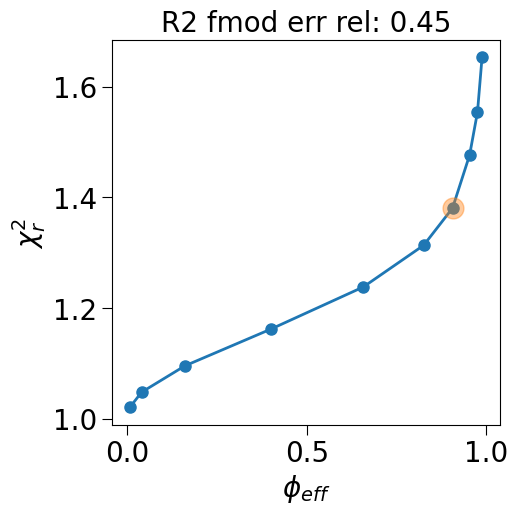

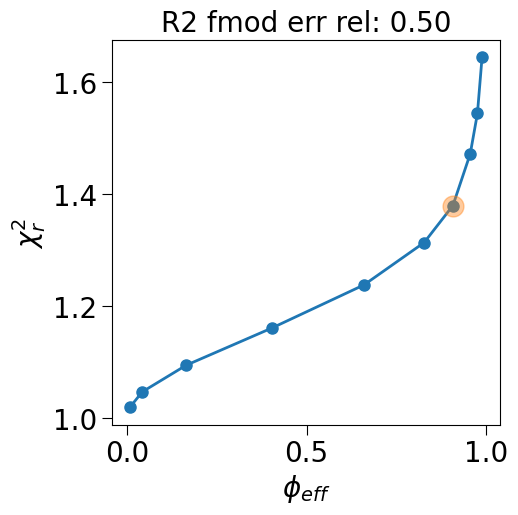

In [6]:
for R2_err in R2_fmoderrrel:
    print(R2_err)
    reweighting_results = load_pickle(f'../7_reweighting_FL/R2_err_fmod_{R2_err}/reweighting.pkl')

    fig = plt.figure(figsize=(5,5))
    
    plt.title(f'R2 fmod err rel: {R2_err}', fontsize=20)
    
    plt.plot(reweighting_results['phi'], reweighting_results['chi2'], 'o-', lw=2, ms=8)

    theta_sel_val = reweighting_results['theta'][theta_sel_R2_and_SAXS]
    print(theta_sel_val)
    plt.plot(reweighting_results['phi'][theta_sel_R2_and_SAXS], reweighting_results['chi2'][theta_sel_R2_and_SAXS], 'o', ms=15, alpha=0.4, label=f'{theta_sel_val}')
        
    plt.xlabel('$\phi_{eff}$', fontsize=20)
    plt.ylabel('$\chi^2_r$', fontsize=20)
    plt.tick_params(colors='black', direction='out', length=7, labelsize=20)
        
    save_pickle(f'../7_reweighting_FL/R2_err_fmod_{R2_err}/weights.pkl', reweighting_results['weights'][theta_sel_R2_and_SAXS])
    
    print(reweighting_results['chi2'][theta_sel_R2_and_SAXS])
    

In [7]:
for R2_err in R2_fmoderrrel:
    #Check phi-eff from uniform weights
    weights = load_pickle(f'../7_reweighting_FL/R2_err_fmod_{R2_err}/weights.pkl')
    weights_uniform = np.array([1]*len(weights))/len(weights)

    phi_eff_touniform = np.exp(-srel(weights_uniform, weights))

    print(f'R2 weight: {R2_err}, Phi_eff to uniform weights: {phi_eff_touniform}')

R2 weight: 0.00, Phi_eff to uniform weights: 0.2607730694562502
R2 weight: 0.05, Phi_eff to uniform weights: 0.2599834762666737
R2 weight: 0.10, Phi_eff to uniform weights: 0.259116650824785
R2 weight: 0.15, Phi_eff to uniform weights: 0.25775464047521696
R2 weight: 0.20, Phi_eff to uniform weights: 0.25755438283005383
R2 weight: 0.25, Phi_eff to uniform weights: 0.25751791533765306
R2 weight: 0.30, Phi_eff to uniform weights: 0.25794349169752673
R2 weight: 0.35, Phi_eff to uniform weights: 0.258473560361502
R2 weight: 0.40, Phi_eff to uniform weights: 0.26166619869454255
R2 weight: 0.45, Phi_eff to uniform weights: 0.2621643156771865
R2 weight: 0.50, Phi_eff to uniform weights: 0.2616530837915929


## R2 diff

In [8]:
dR2_calc = load_sim_SAXS('../7_reweighting_FL/AB_seq_DBD_hinge_LBD_contacts_CA_allresis_R2diff_BMEcalc.dat')
residue, dR2_exp, dR2_err_exp = load_exp_SAXS('../7_reweighting_FL/AB_seq_DBD_hinge_LBD_contacts_CA_allresis_R2diff_BMEexpt.dat')

if priortype == 'weighted':
    weights_prior = load_pickle('../6_reweighting_dAB/weights.pkl')
    dR2_avg = np.average(dR2_calc, axis=0, weights=weights_prior)
elif priortype == 'uniform':
    dR2_avg = np.average(dR2_calc, axis=0)
else:
    raise Exception('No')

<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:55: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:55: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894491/1937203491.py:38: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta R_2$ (s$^{-1}$) / ⟨Contacts⟩ (A.U.)', fontsize=20)
/tmp/ipykernel_2894491/1937203491.py:55: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta R_2$ (s$^{-1}$)', fontsize=20)
/tmp/ipykernel_2894491/1937203491.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8,4))


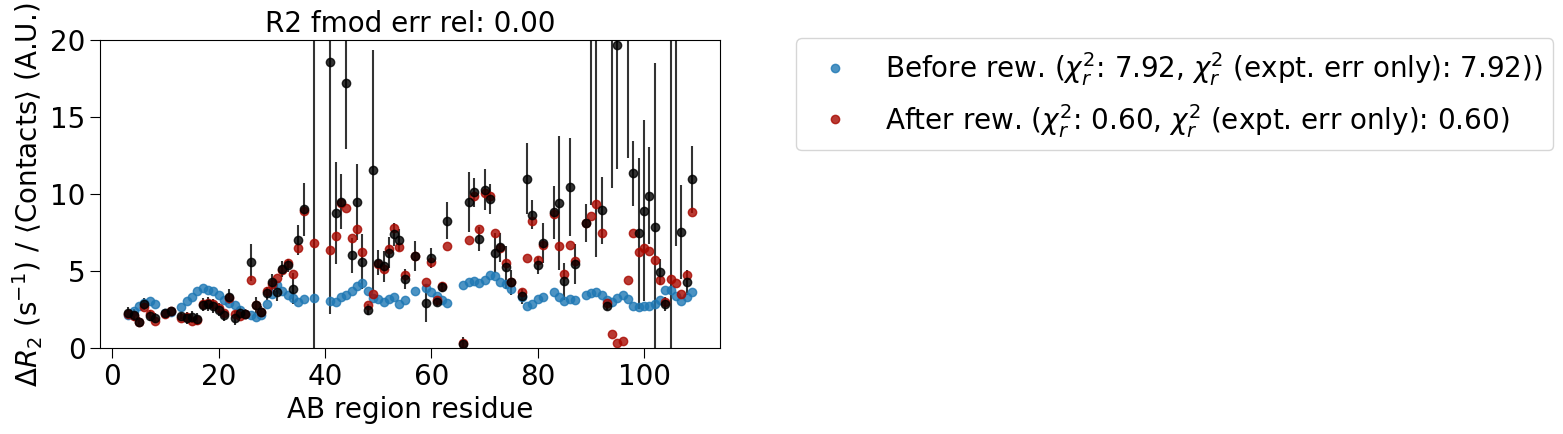

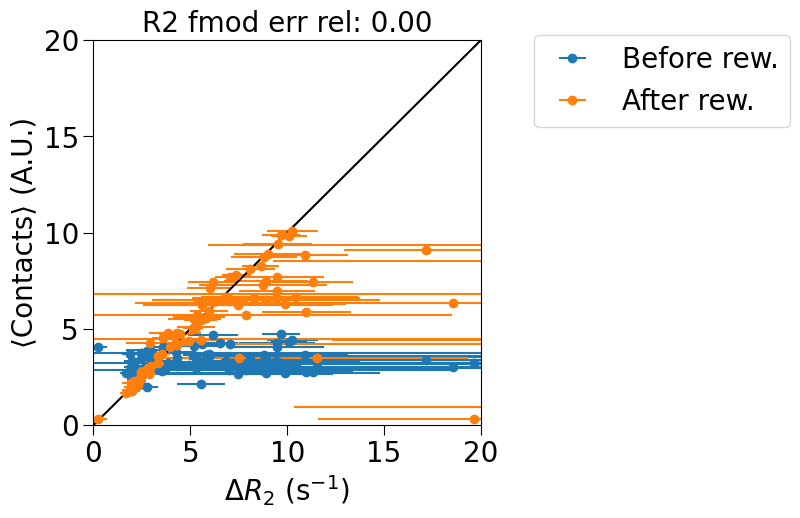

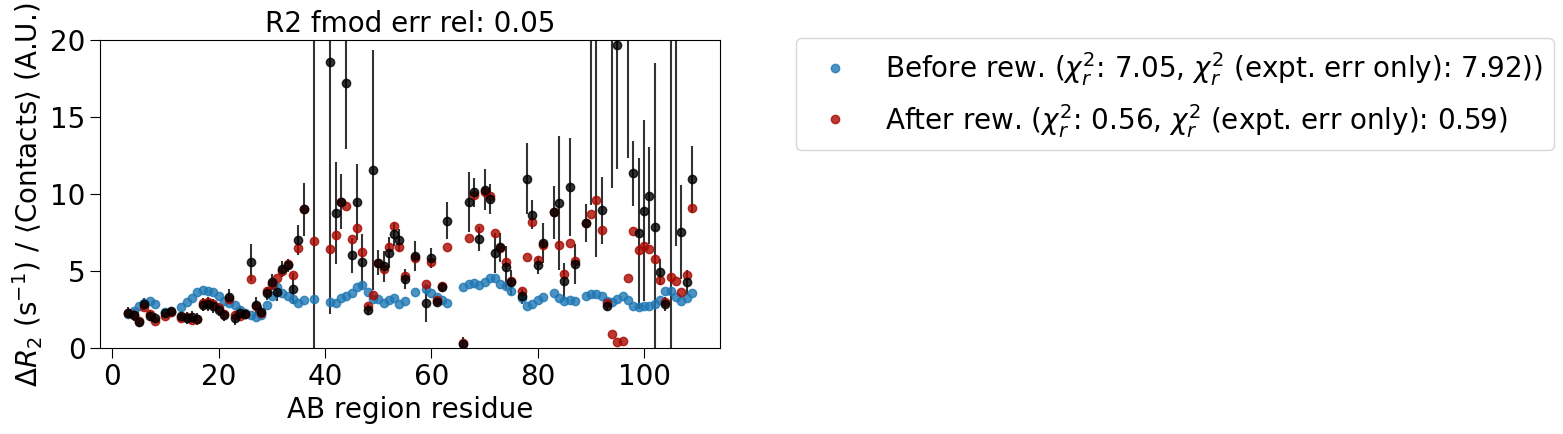

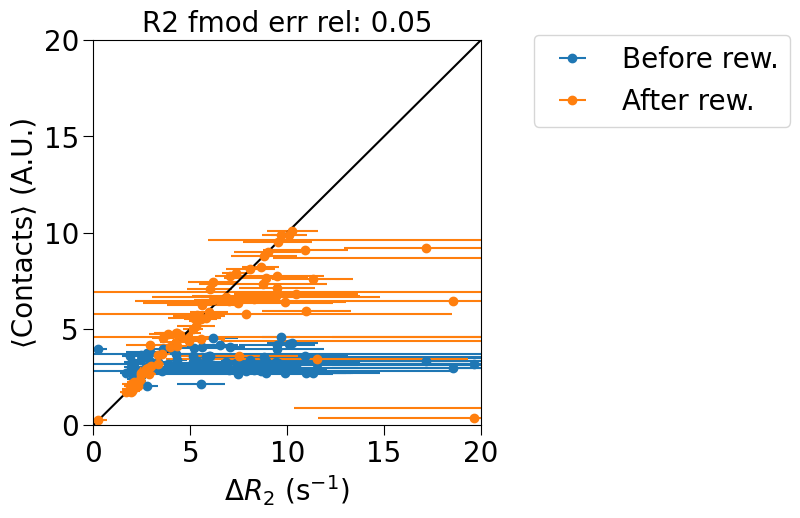

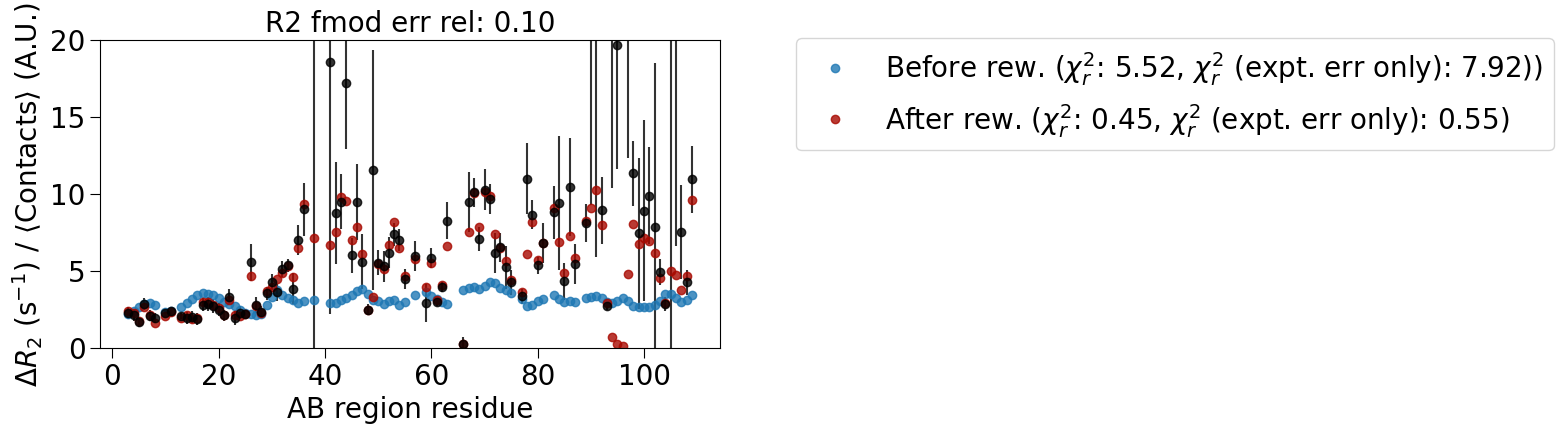

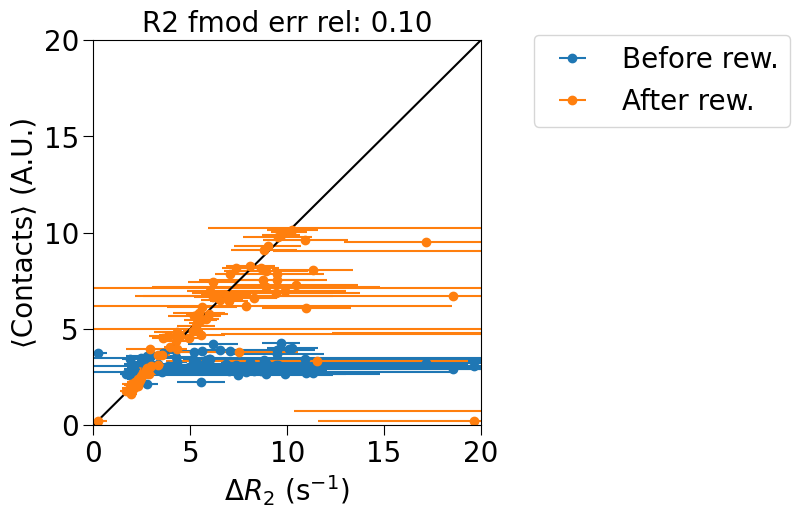

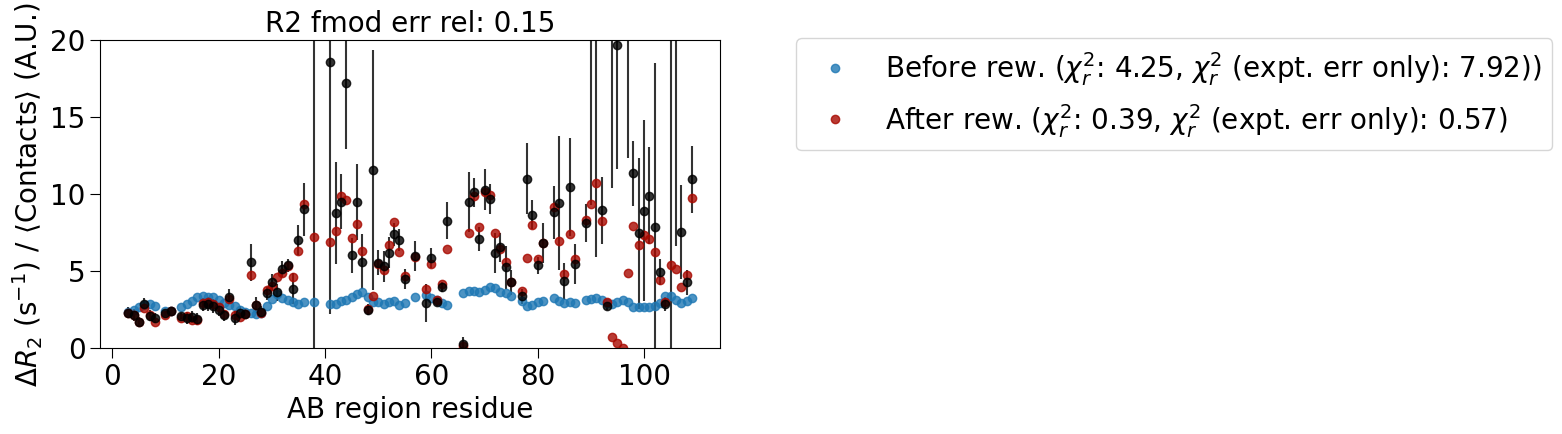

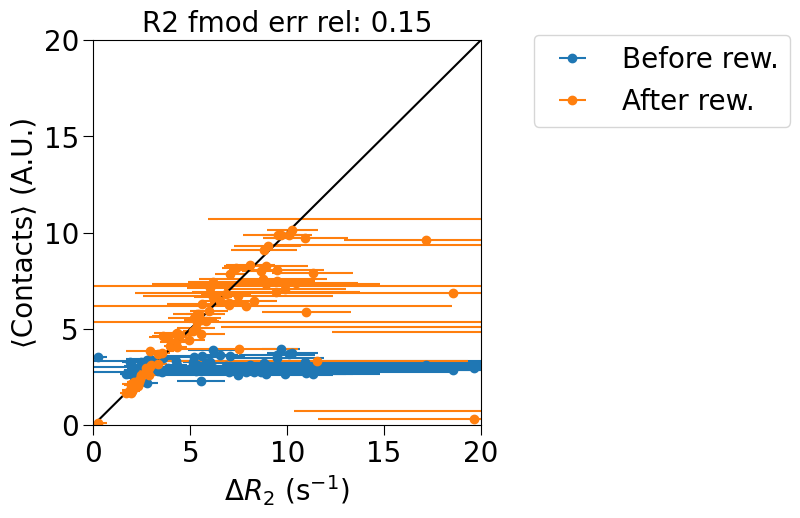

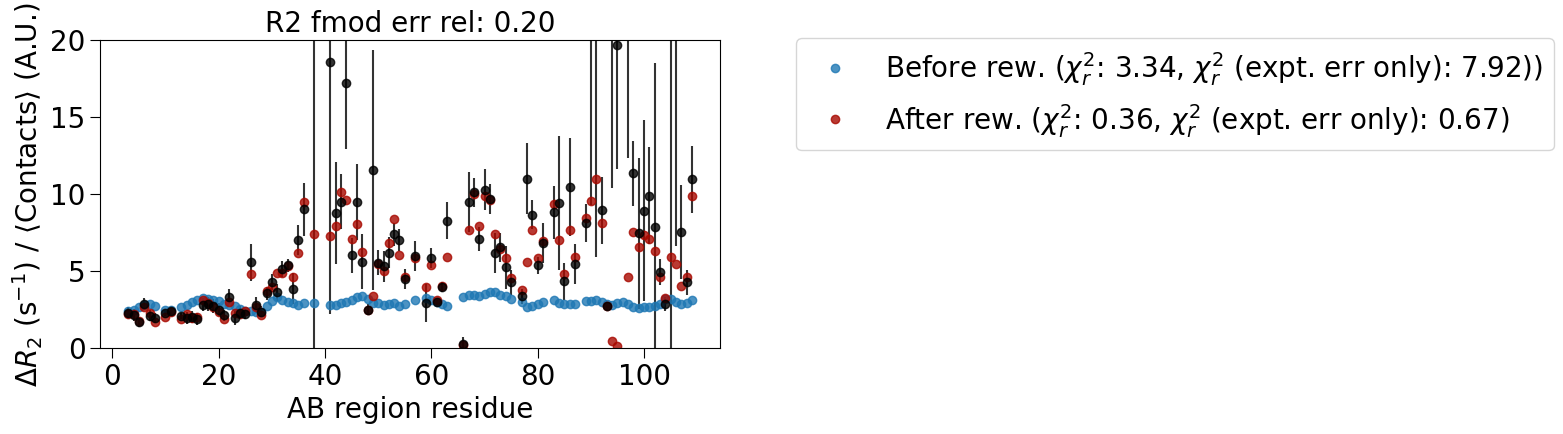

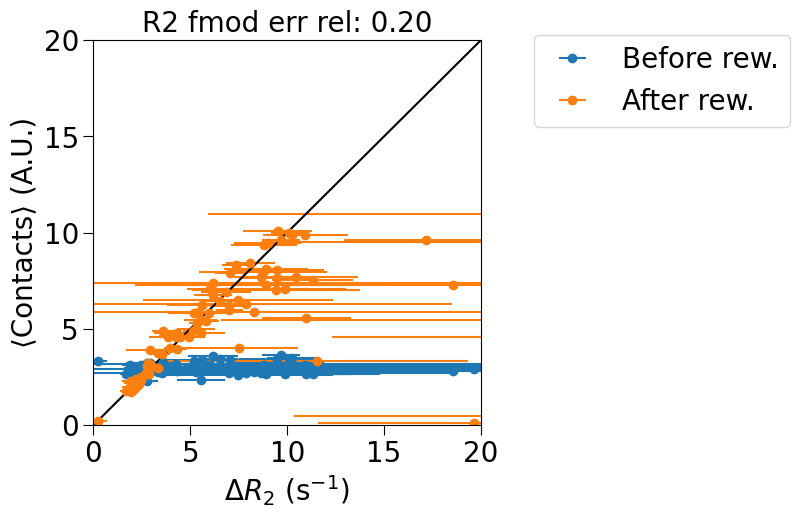

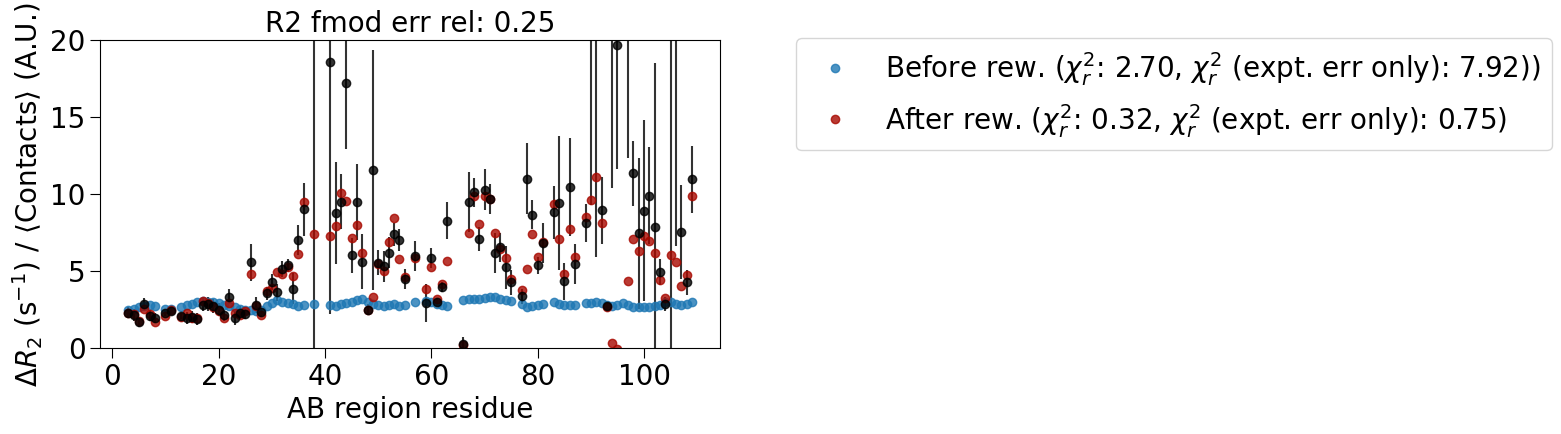

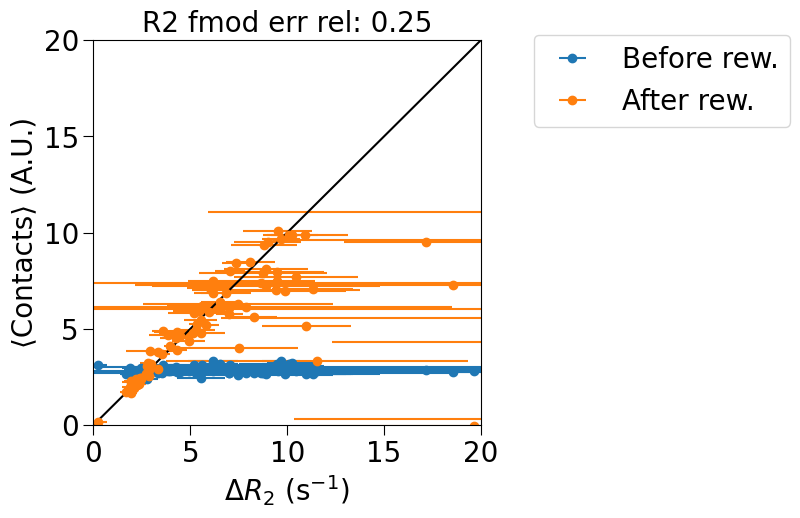

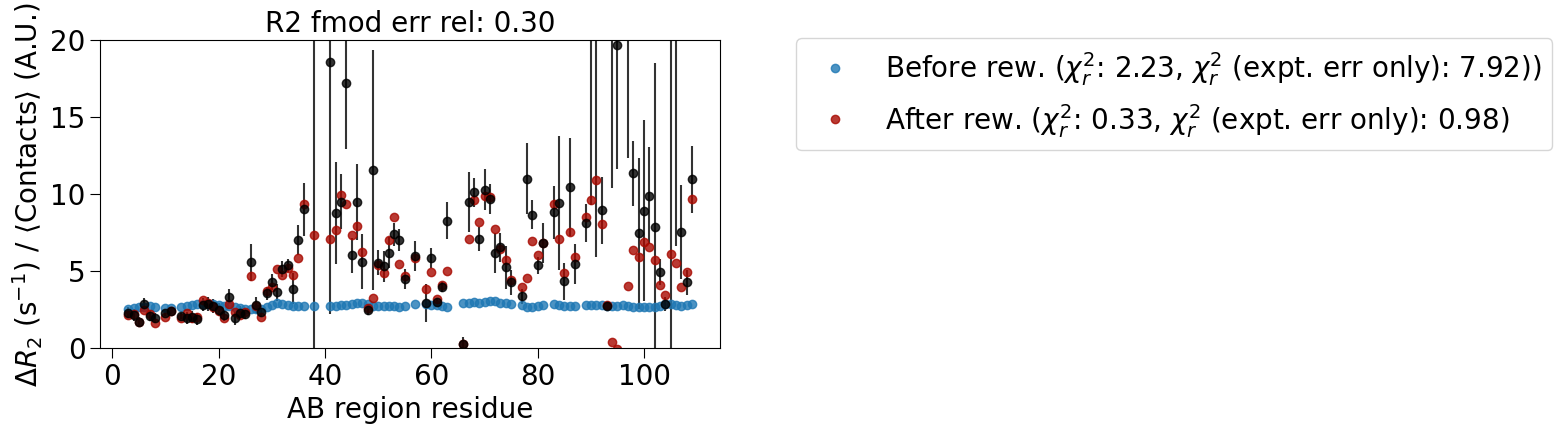

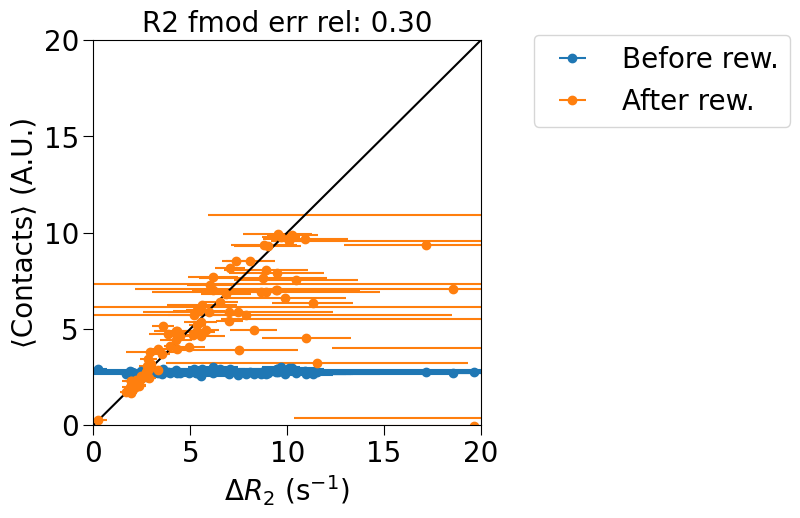

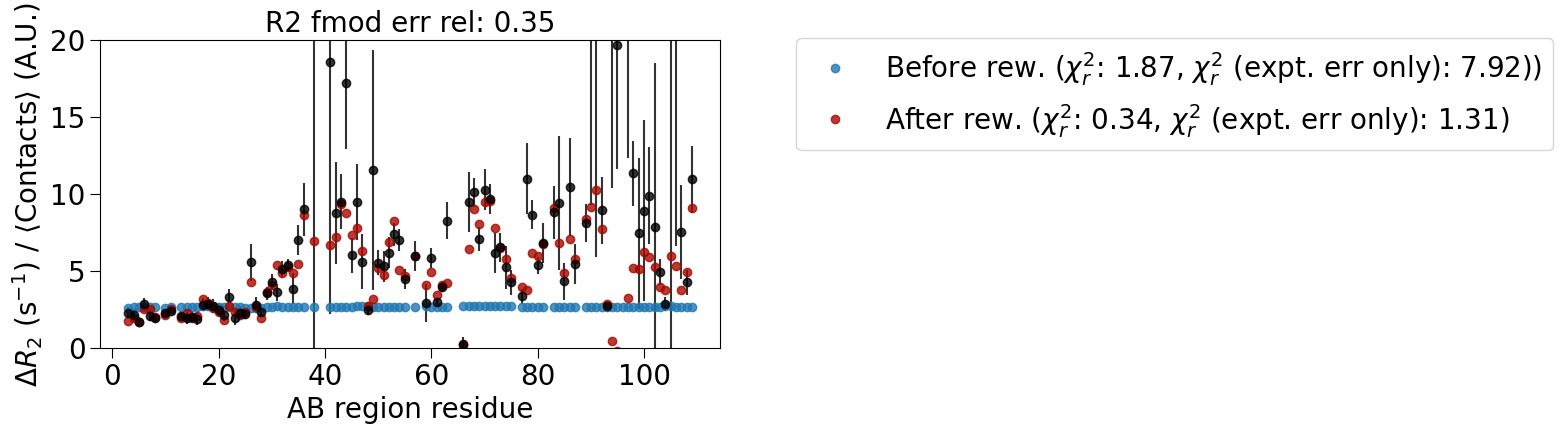

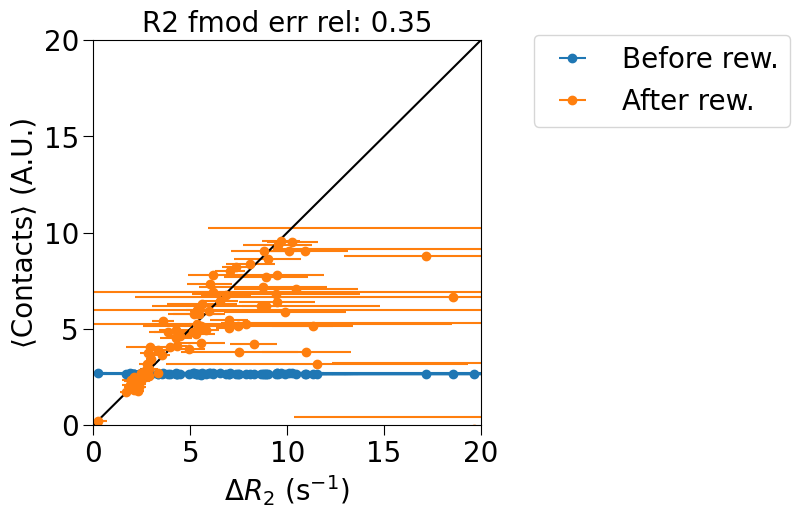

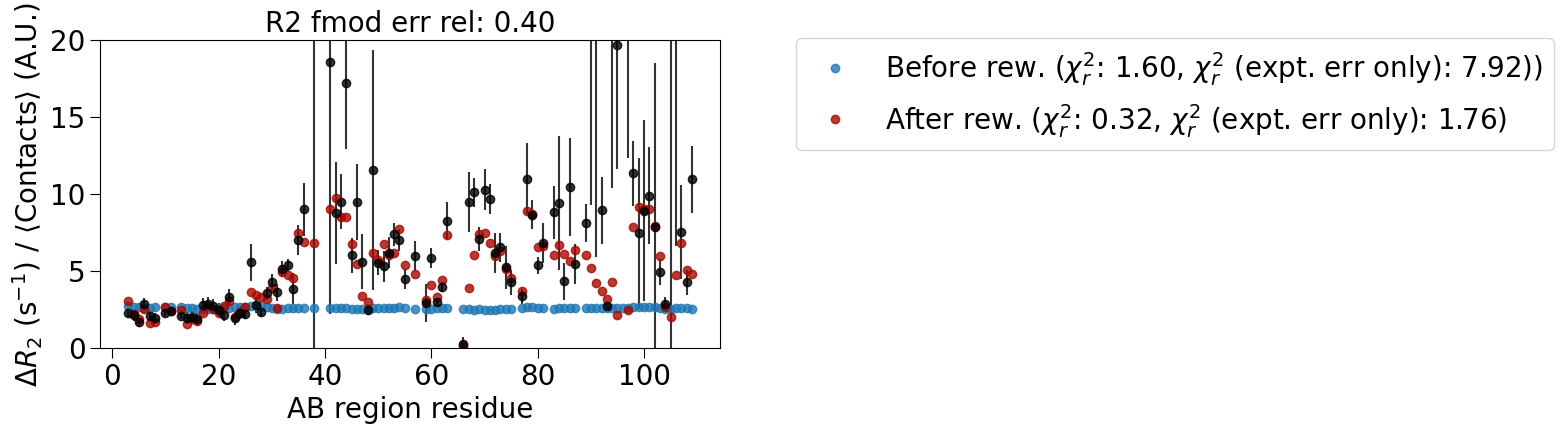

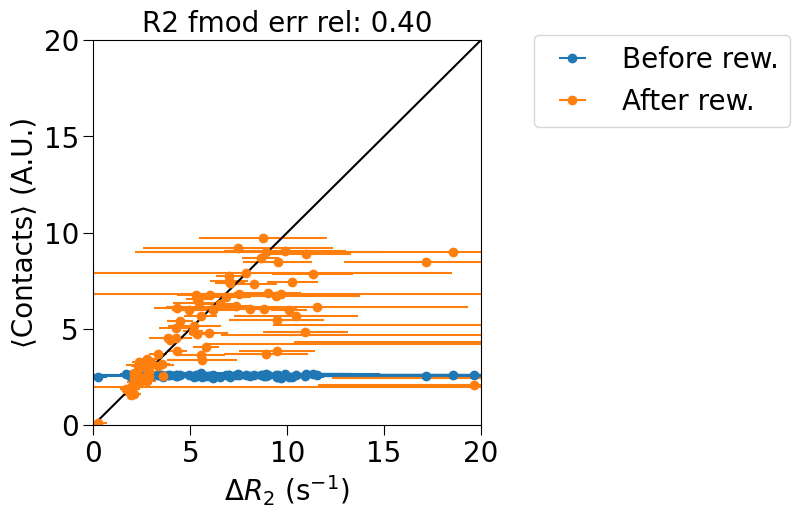

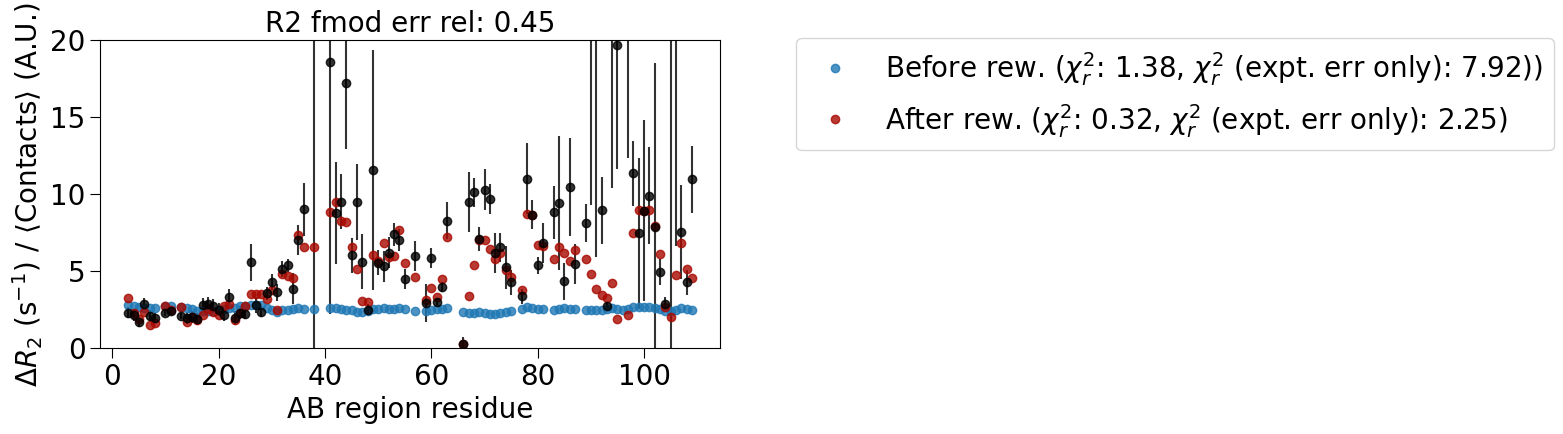

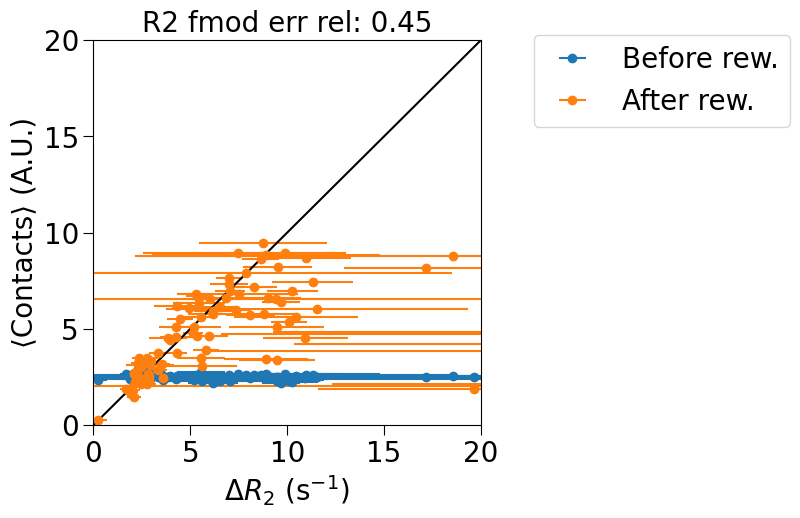

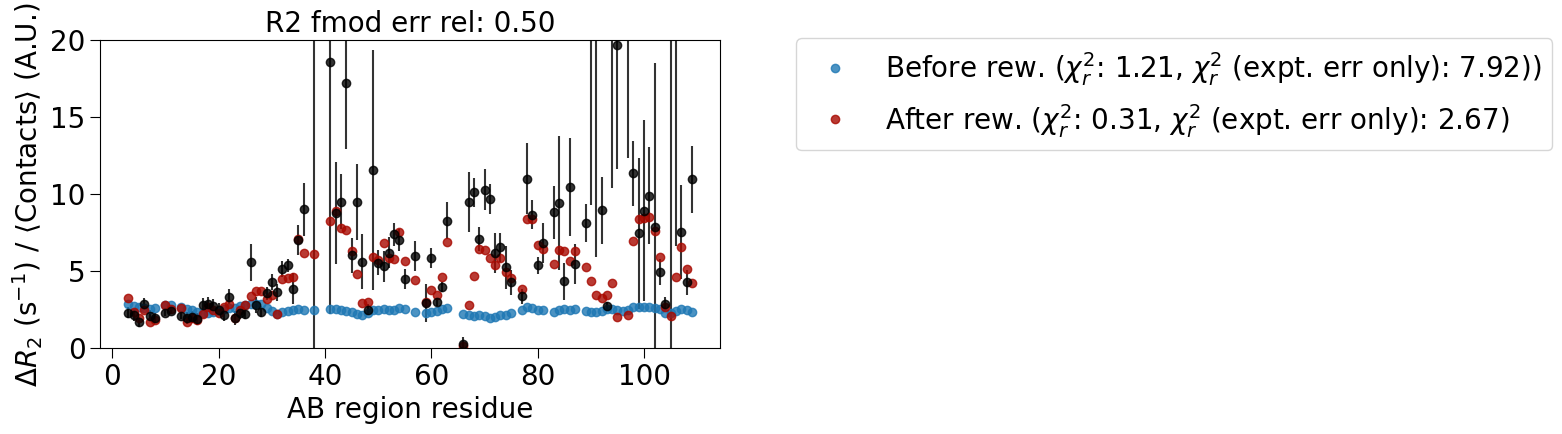

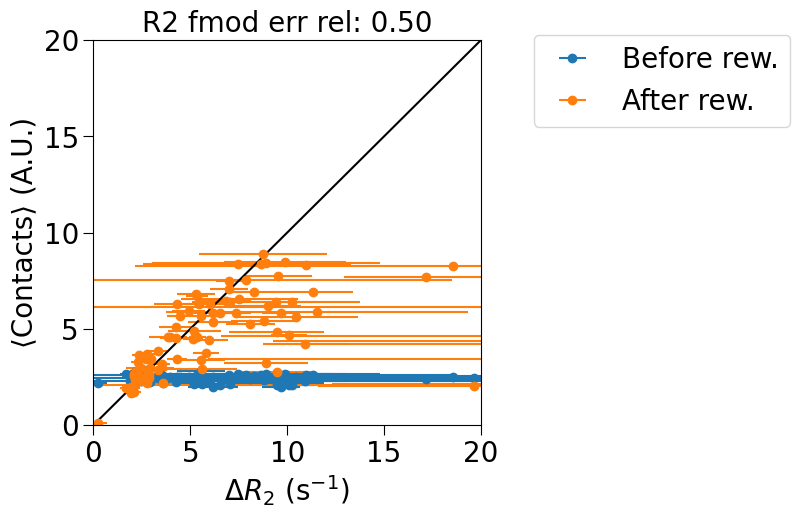

In [9]:
dR2_avg_scaleoffset, slope, intercept, r_value = fit_scale_offset(dR2_avg, dR2_exp, dR2_err_exp)
chi2 = get_chi2(dR2_avg_scaleoffset, dR2_exp, dR2_err_exp)

chi2_fmoderr_vs_R2_err = []
chi2_rew_fmoderr_vs_R2_err = []
chi2_rew_vs_R2_err = []
for R2_err in R2_fmoderrrel:
    
    #Get errors on dR2 (with fmod)
    dR2_err_exp_fmoderr = np.sqrt(np.square(dR2_err_exp) + np.square(dR2_exp*float(R2_err)))

    #Get chi2 before reweighting with updated dR2 err
    dR2_avg_scaleoffset_fmoderr, slope, intercept, r_value = fit_scale_offset(dR2_avg, dR2_exp, dR2_err_exp_fmoderr)
    chi2_fmoderr = get_chi2(dR2_avg_scaleoffset_fmoderr, dR2_exp, dR2_err_exp_fmoderr)
    chi2_fmoderr_vs_R2_err.append(chi2_fmoderr)
    
    #Get chi2 after reweighting with updated dR2 err
    weights = load_pickle(f'../7_reweighting_FL/R2_err_fmod_{R2_err}/weights.pkl')
    dR2_avg_rew = np.average(dR2_calc, axis=0, weights=weights)
    dR2_avg_rew_scaleoffset_fmoderr, slope, intercept, r_value = fit_scale_offset(dR2_avg_rew, dR2_exp, dR2_err_exp_fmoderr)
    chi2_rew_fmoderr = get_chi2(dR2_avg_rew_scaleoffset_fmoderr, dR2_exp, dR2_err_exp_fmoderr)
    chi2_rew_fmoderr_vs_R2_err.append(chi2_rew_fmoderr)
    
    #Get chi2 after reweighting with no update to dR2 err
    dR2_avg_rew_scaleoffset, slope, intercept, r_value = fit_scale_offset(dR2_avg_rew, dR2_exp, dR2_err_exp)
    chi2_rew = get_chi2(dR2_avg_rew_scaleoffset, dR2_exp, dR2_err_exp)
    chi2_rew_vs_R2_err.append(chi2_rew)
    
    fig = plt.figure(figsize=(8,4))
    
    plt.title(f'R2 fmod err rel: {R2_err}', fontsize=20)
    
    plt.errorbar(residue, dR2_exp, yerr=dR2_err_exp, fmt='o', c='black', alpha=0.8)
    plt.plot(residue, dR2_avg_scaleoffset_fmoderr, 'o', alpha=0.8, label=f'Before rew. ($χ^2_r$: {chi2_fmoderr:.2f}, $χ^2_r$ (expt. err only): {chi2:.2f}))', c=colors[0])
    plt.plot(residue, dR2_avg_rew_scaleoffset_fmoderr, 'o', alpha=0.8, label=f'After rew. ($χ^2_r$: {chi2_rew_fmoderr:.2f}, $χ^2_r$ (expt. err only): {chi2_rew:.2f})', c=colors[1])

    plt.xlabel('AB region residue', fontsize=20)
    plt.ylabel('$\Delta R_2$ (s$^{-1}$) / ⟨Contacts⟩ (A.U.)', fontsize=20)
    plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

    plt.legend(fontsize=20, bbox_to_anchor=(1.1, 1.05))
    plt.ylim(0,20)
    
    fig = plt.figure(figsize=(5,5))

    plt.title(f'R2 fmod err rel: {R2_err}', fontsize=20)

    plt.errorbar(dR2_exp, dR2_avg_scaleoffset_fmoderr, xerr=dR2_err_exp, fmt='o', label='Before rew.')
    plt.errorbar(dR2_exp, dR2_avg_rew_scaleoffset_fmoderr, xerr=dR2_err_exp, fmt='o', label='After rew.')

    plt.plot([0,100], [0,100], c='black')

    plt.legend(fontsize=20, bbox_to_anchor=(1.1, 1.05))

    plt.xlabel('$\Delta R_2$ (s$^{-1}$)', fontsize=20)
    plt.ylabel('⟨Contacts⟩ (A.U.)', fontsize=20)
    plt.tick_params(colors='black', direction='out', length=7, labelsize=20)
    
    max_lim = np.amax(np.concatenate((dR2_avg_scaleoffset_fmoderr, dR2_avg_rew_scaleoffset_fmoderr, dR2_exp)))
    max_lim *= 1.1
    
    #plt.xlim(0,max_lim)
    #plt.ylim(0,max_lim)
    
    plt.xlim(0,20)
    plt.ylim(0,20)
    


## SAXS reweighting

In [10]:
SAXS = load_sim_SAXS('../7_reweighting_FL/calc_SAXS_free_joined.dat')

In [11]:
if priortype == 'weighted':
    weights_prior = load_pickle('../6_reweighting_dAB/weights.pkl')
    SAXS_avg = np.average(SAXS, axis=0, weights=weights_prior)
elif priortype == 'uniform':
    SAXS_avg = np.average(SAXS, axis=0)
else:
    raise Exception('No')

R2 fmod err rel: 0.00, chi2 before: 2.098385432829676, chi2 after: 1.4398853936494858
R2 fmod err rel: 0.05, chi2 before: 2.098385432829676, chi2 after: 1.4396134156713751
R2 fmod err rel: 0.10, chi2 before: 2.098385432829676, chi2 after: 1.4392506656398558
R2 fmod err rel: 0.15, chi2 before: 2.098385432829676, chi2 after: 1.4386036691713011
R2 fmod err rel: 0.20, chi2 before: 2.098385432829676, chi2 after: 1.4384424134968121
R2 fmod err rel: 0.25, chi2 before: 2.098385432829676, chi2 after: 1.4382894626301321
R2 fmod err rel: 0.30, chi2 before: 2.098385432829676, chi2 after: 1.4381943972187112
R2 fmod err rel: 0.35, chi2 before: 2.098385432829676, chi2 after: 1.438374176540516
R2 fmod err rel: 0.40, chi2 before: 2.098385432829676, chi2 after: 1.4398622531829375
R2 fmod err rel: 0.45, chi2 before: 2.098385432829676, chi2 after: 1.4398944195538865
R2 fmod err rel: 0.50, chi2 before: 2.098385432829676, chi2 after: 1.4395245964430887


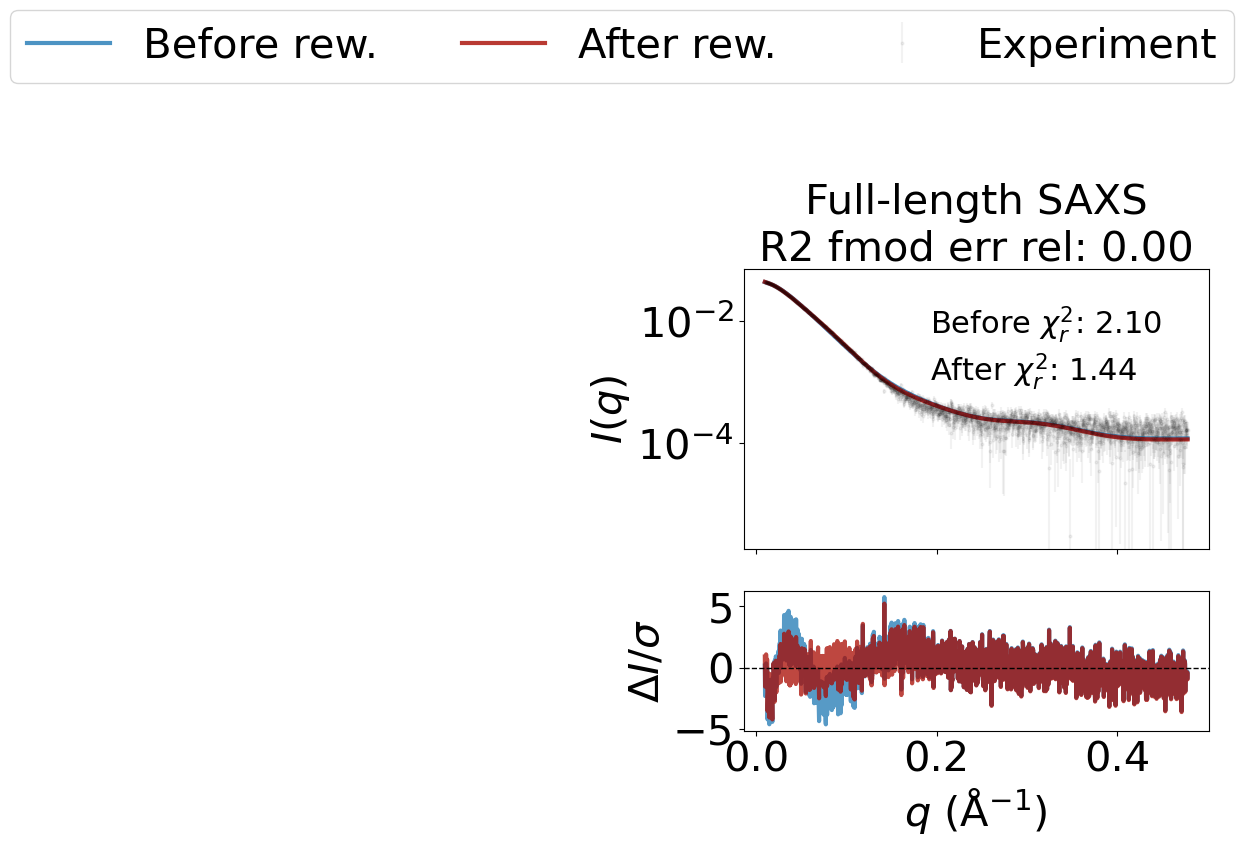

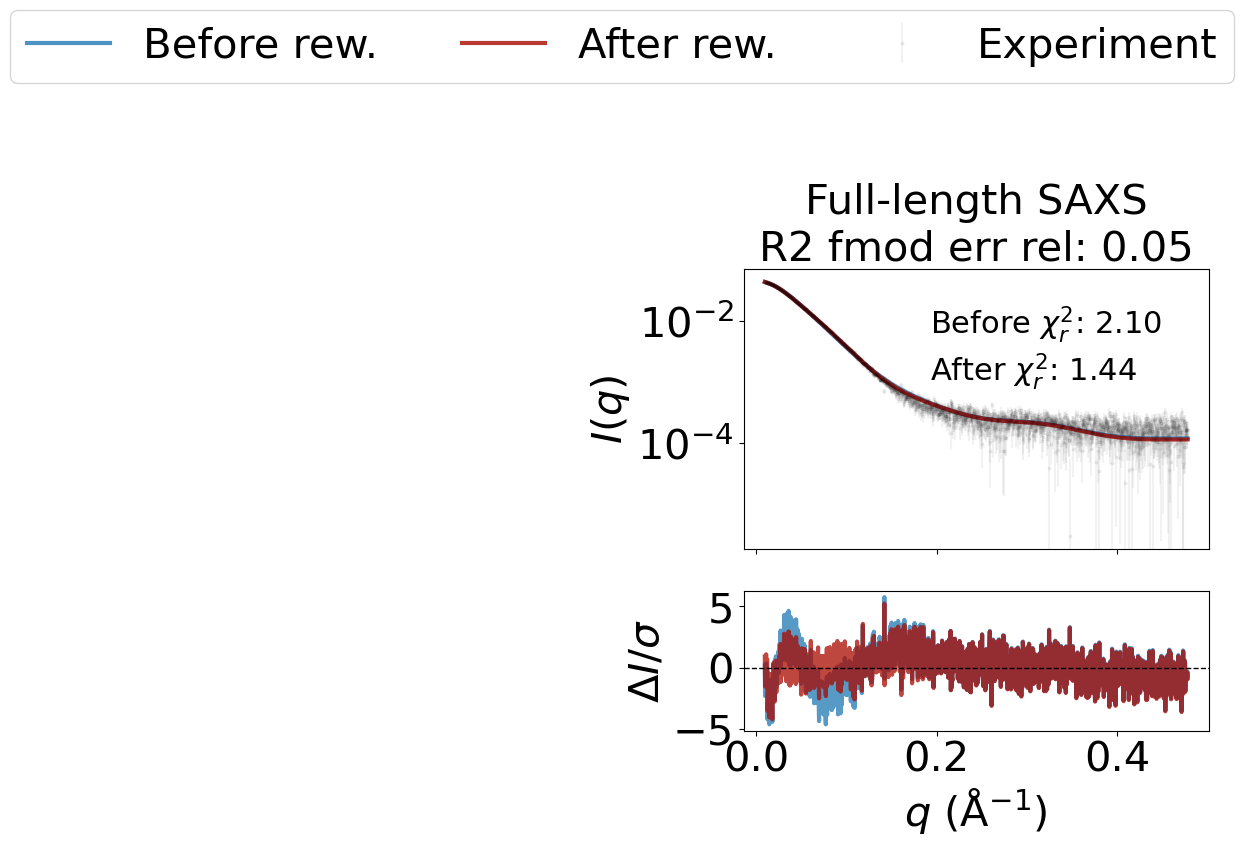

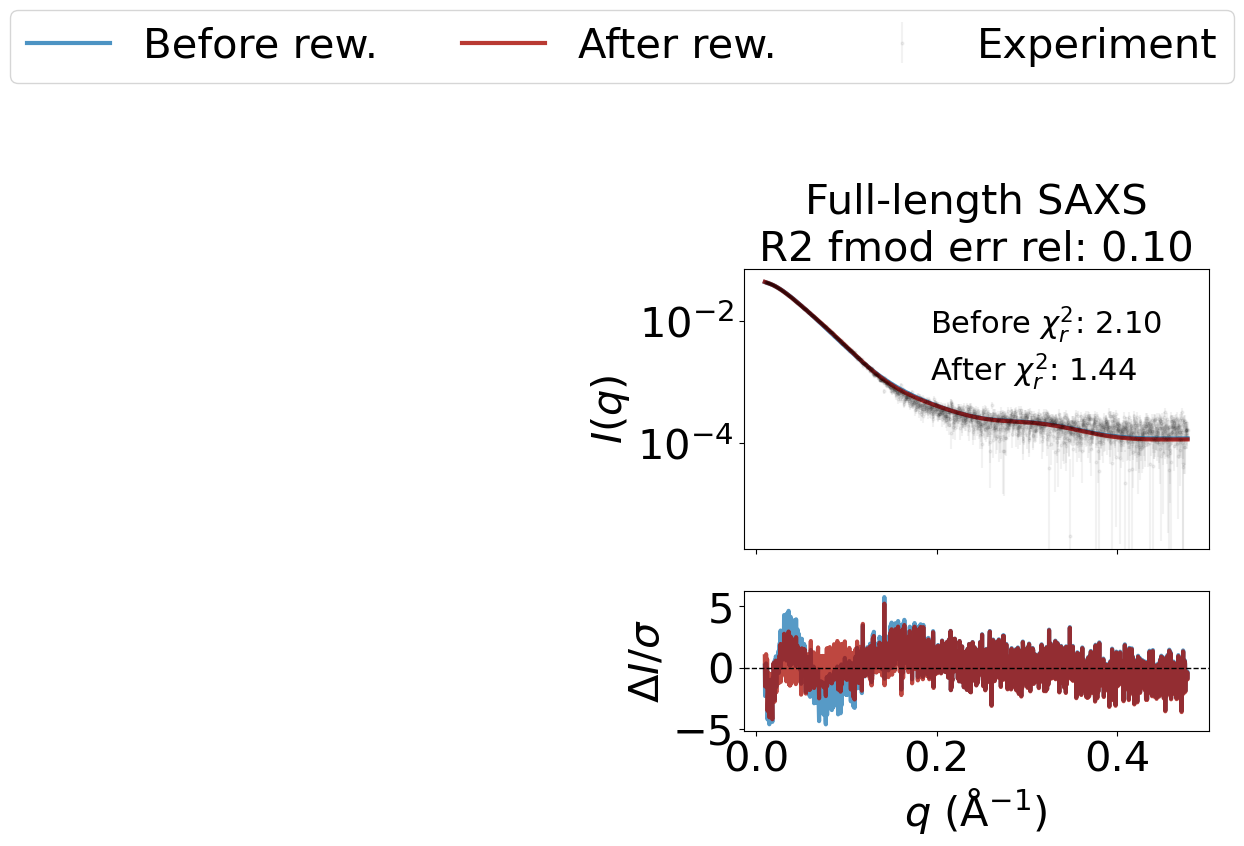

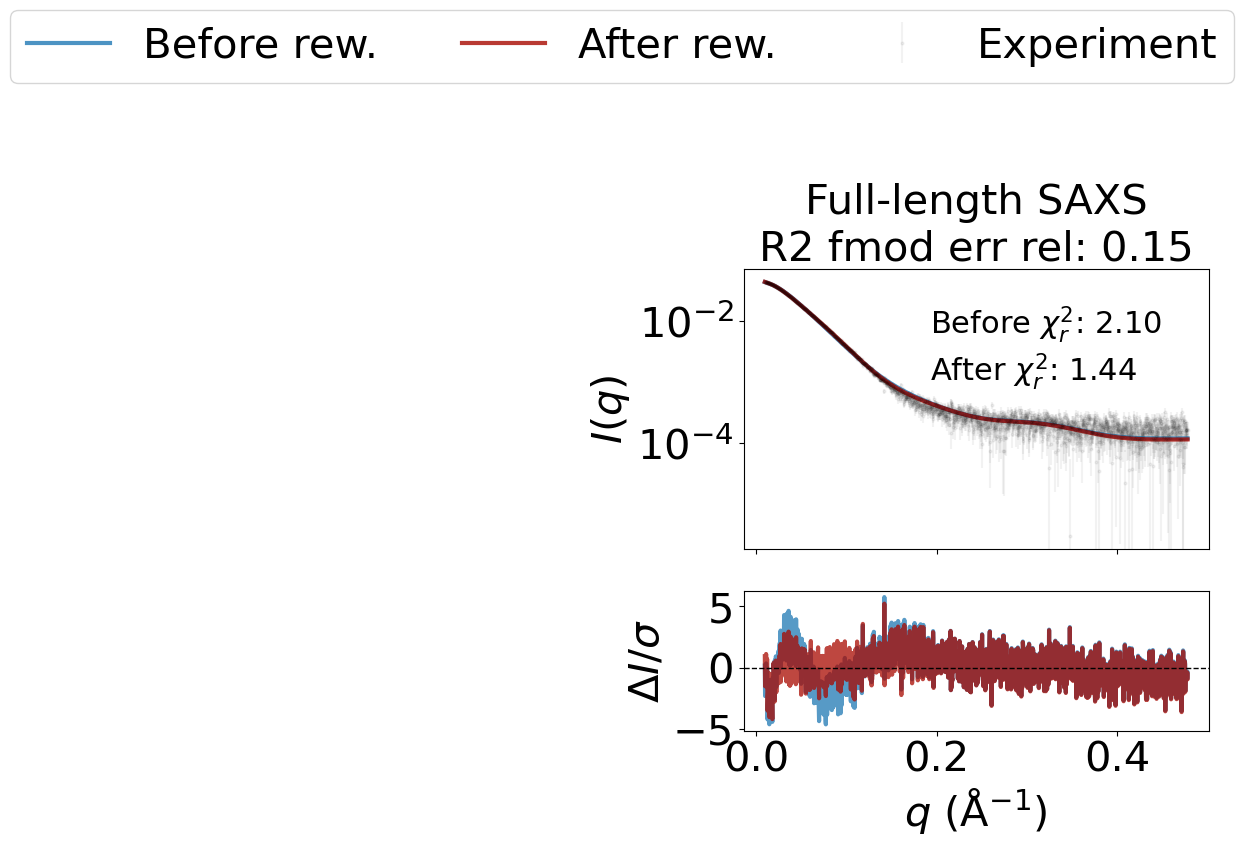

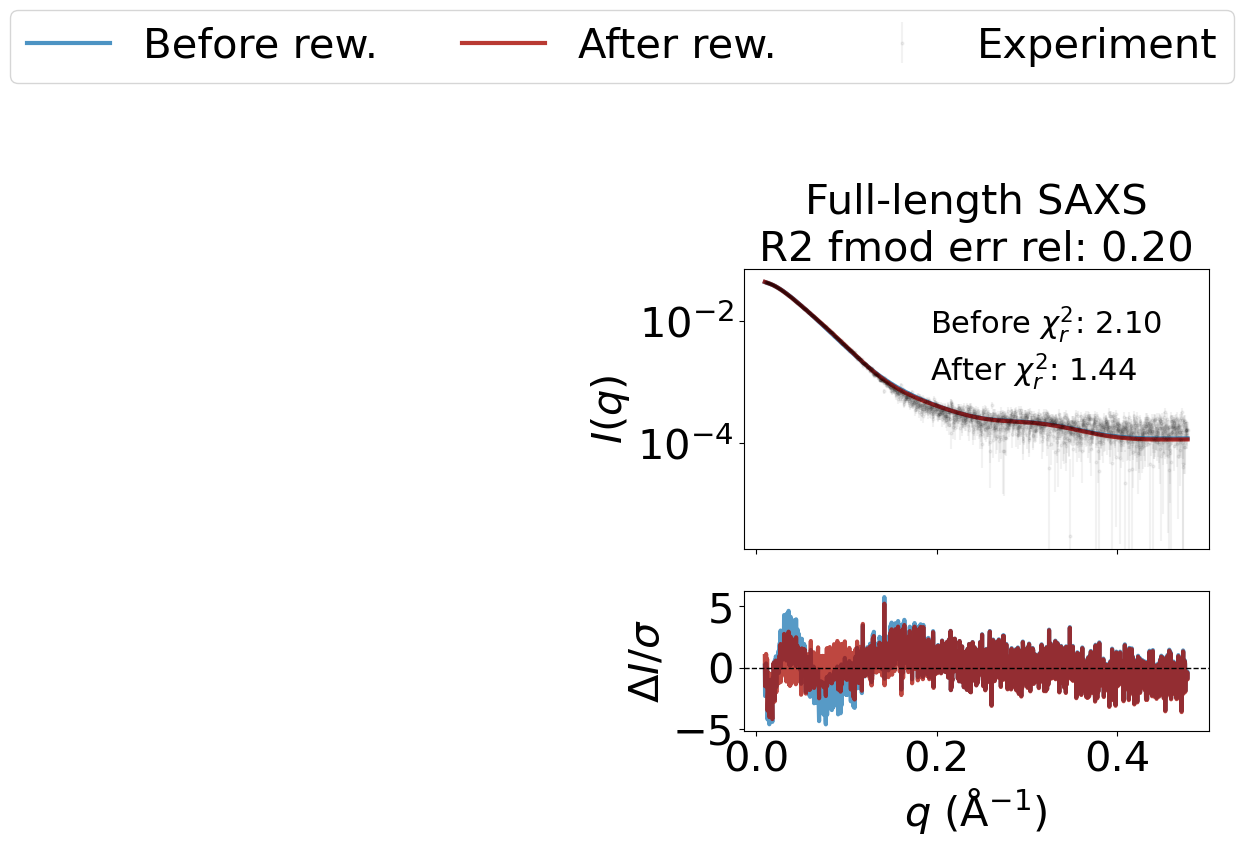

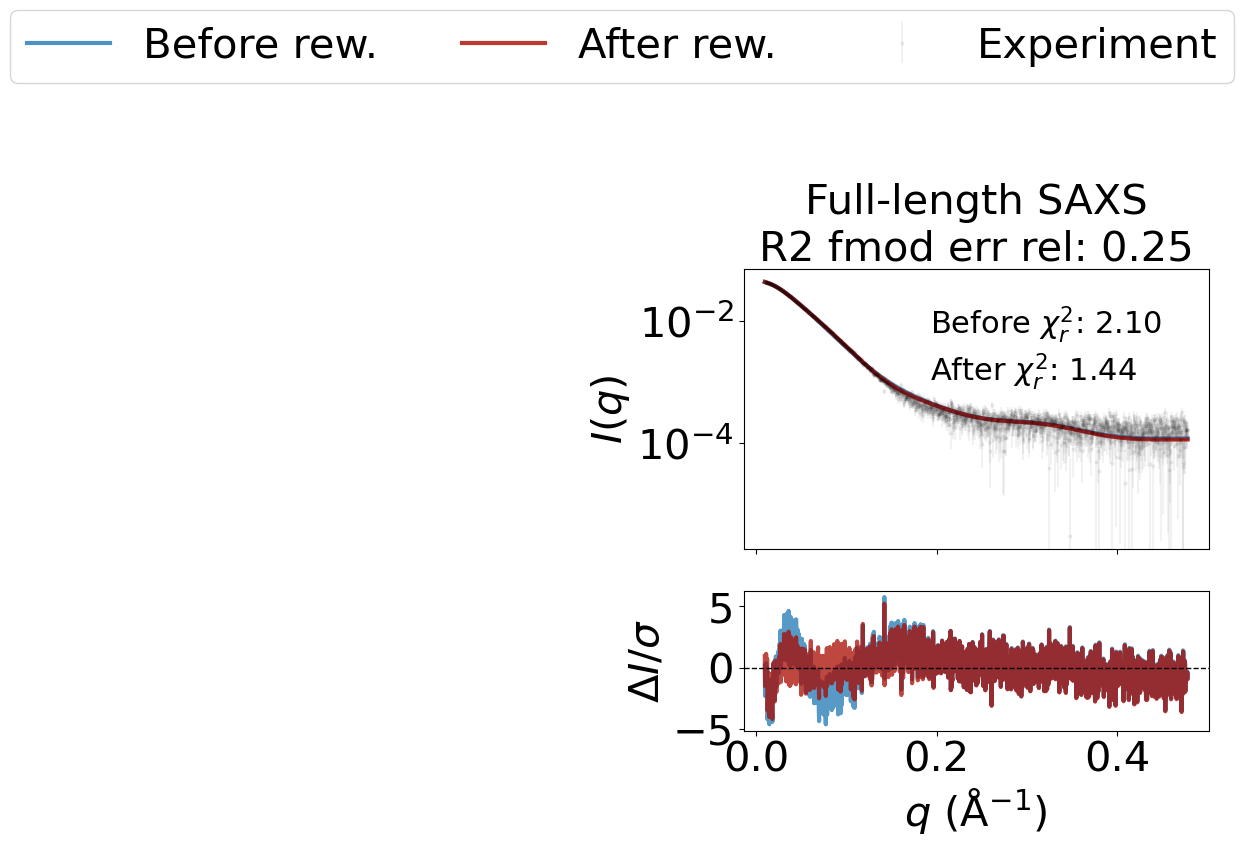

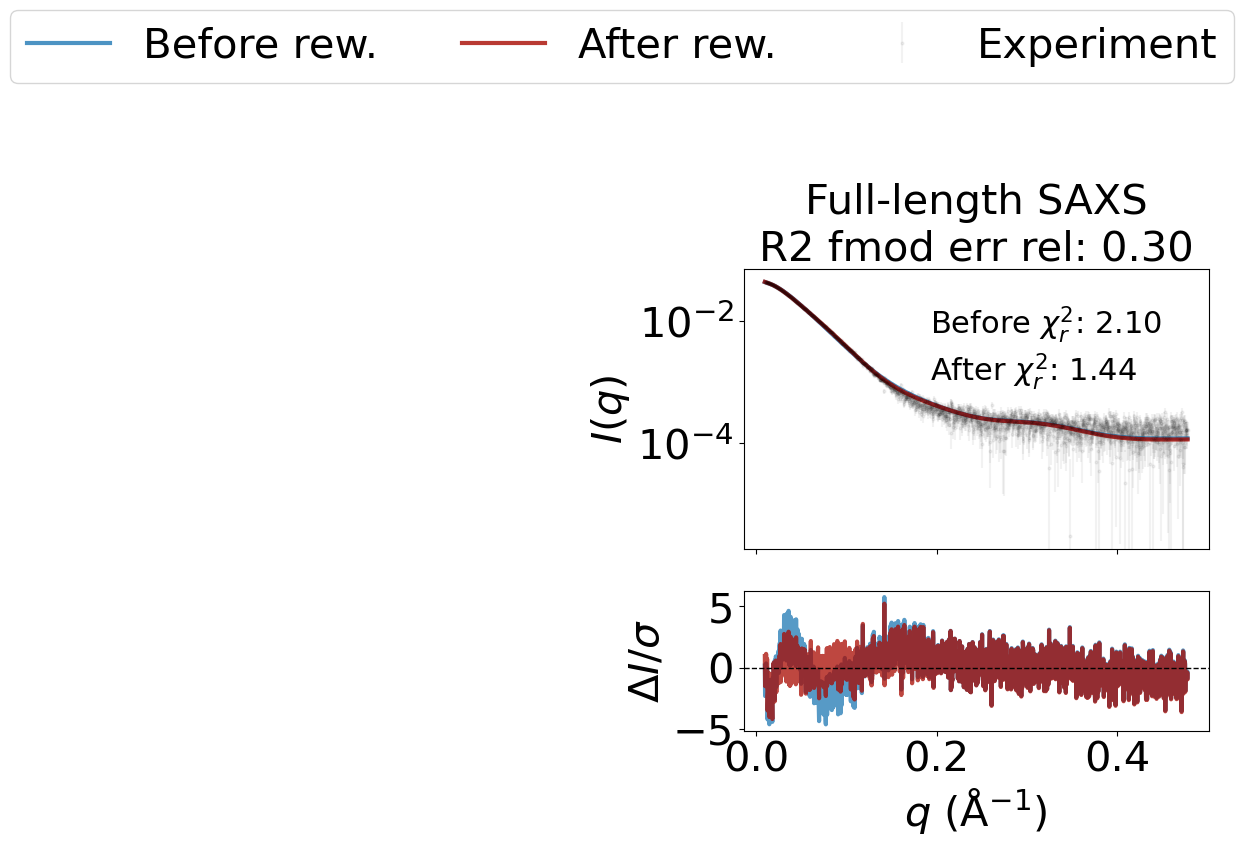

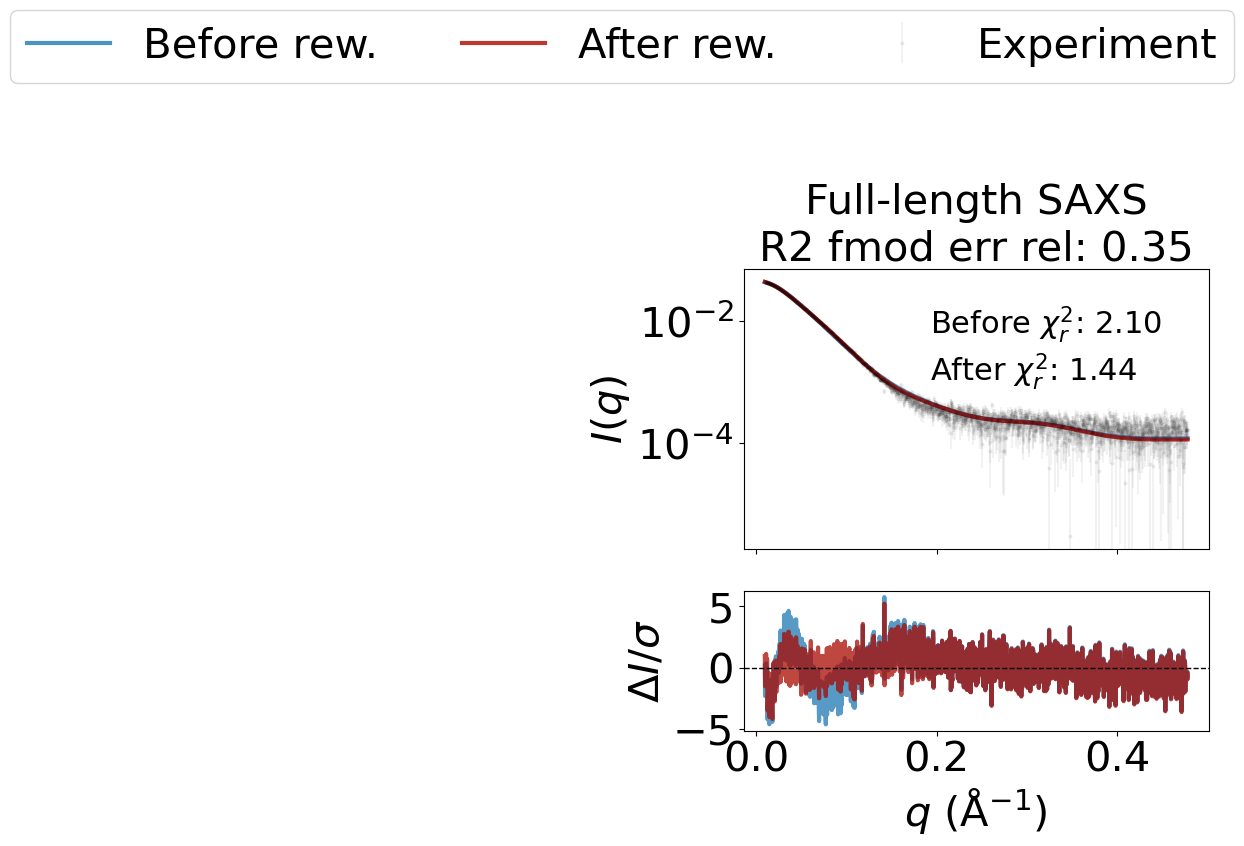

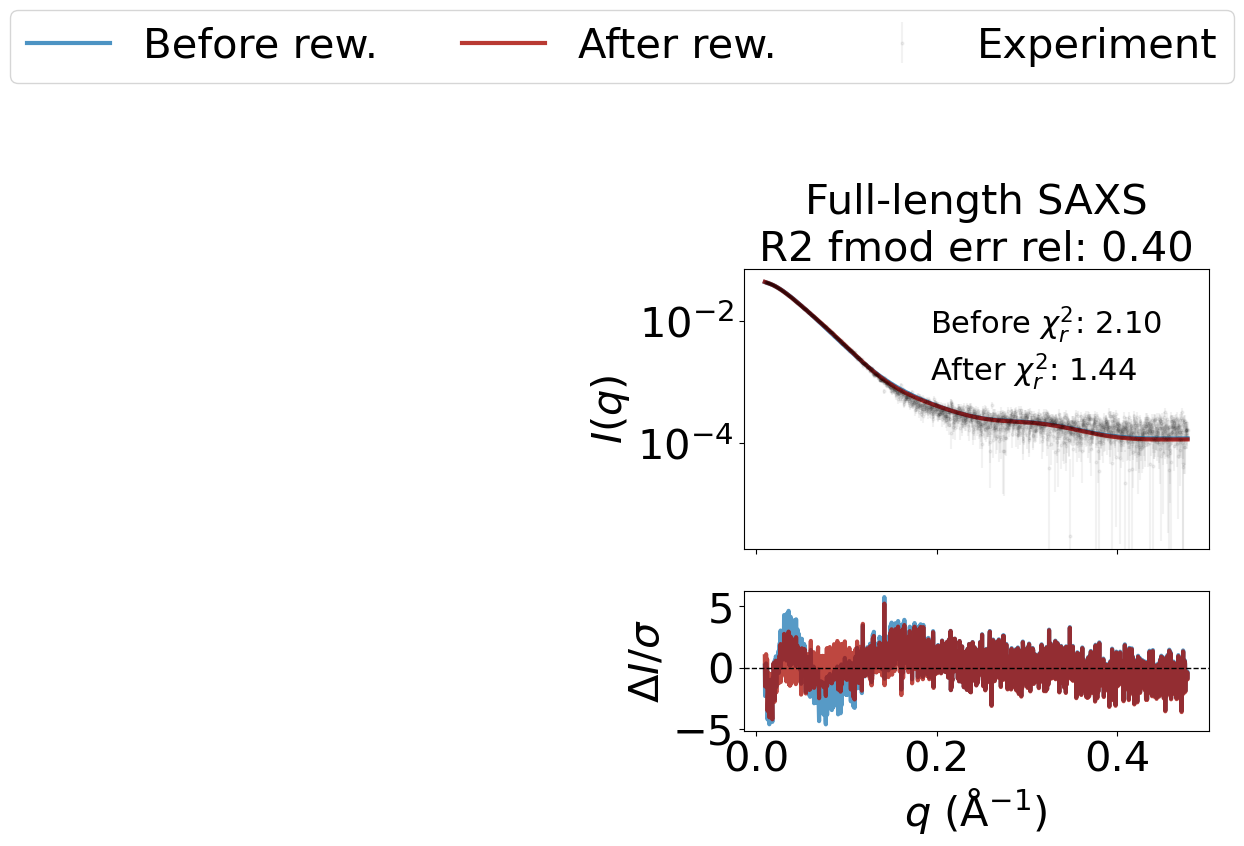

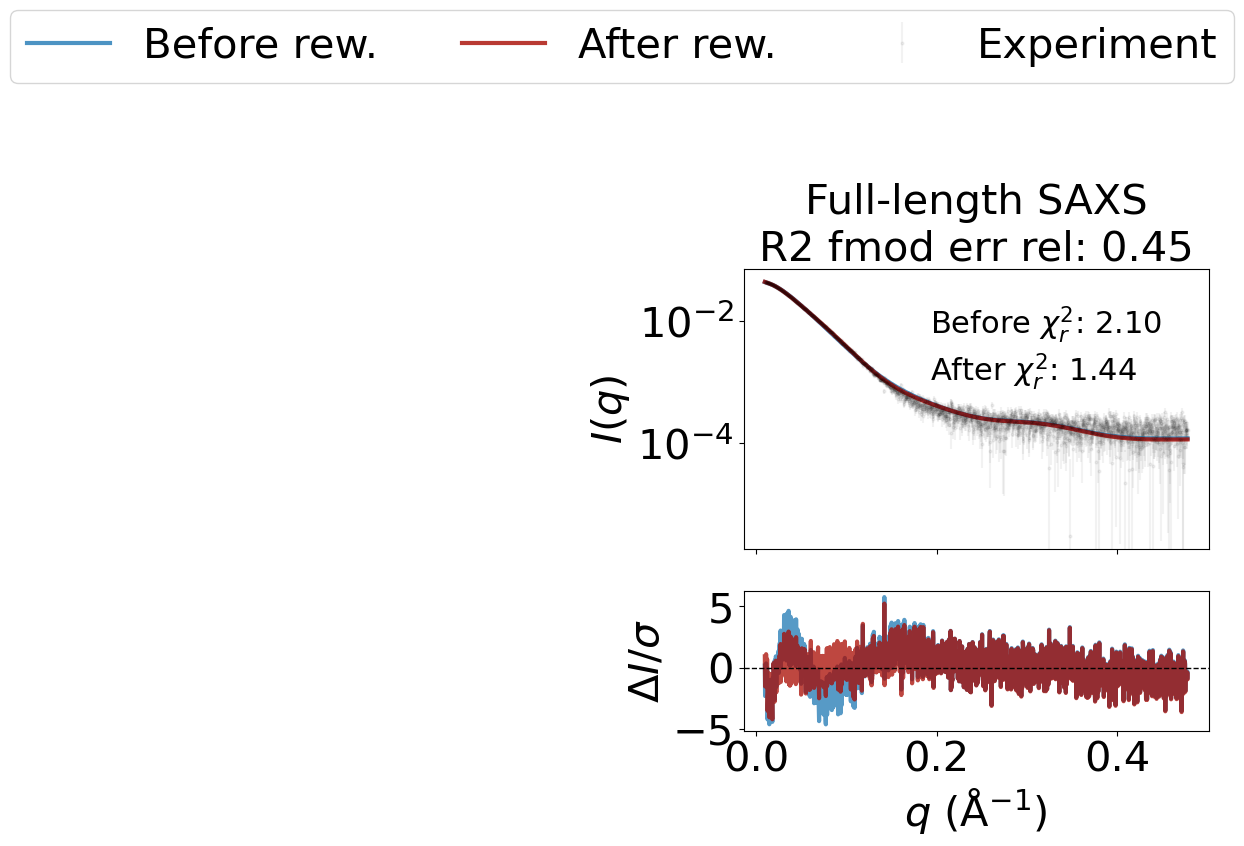

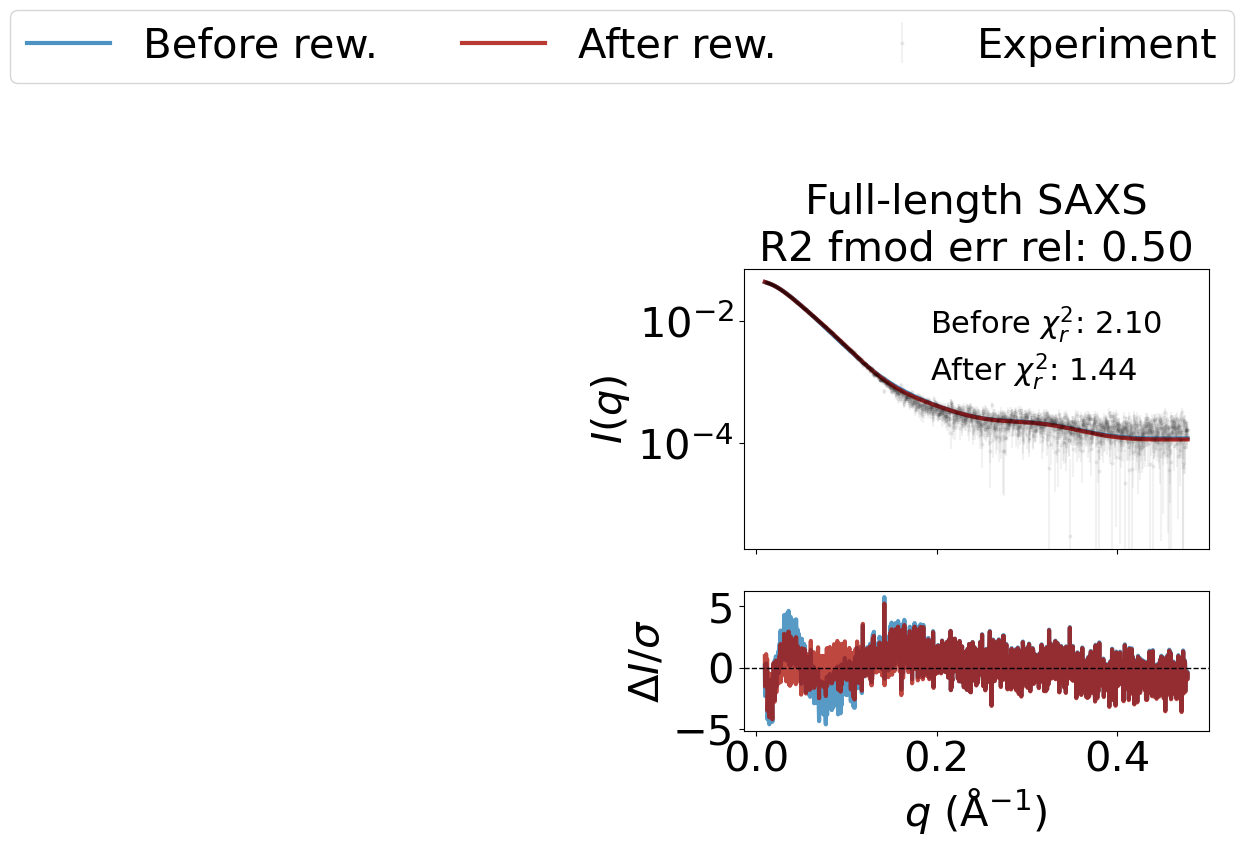

In [12]:
chi2_SAXS_vs_R2fmoderrrel = []
for R2_err in R2_fmoderrrel:

    weights = load_pickle(f'../7_reweighting_FL/R2_err_fmod_{R2_err}/weights.pkl')
    SAXS_avg_rew = np.average(SAXS, axis=0, weights=weights)

    q, I_exp, err_exp = load_exp_SAXS('../7_reweighting_FL/PPARg_lowsalt_SAXSexpt.dat')
    q *= 0.1

    SAXS_avg_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_avg, I_exp, err_exp)
    SAXS_avg_rew_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_avg_rew, I_exp, err_exp)

    chi2 = get_chi2(SAXS_avg_scaleoffset, I_exp, err_exp)
    chi2_rew = get_chi2(SAXS_avg_rew_scaleoffset, I_exp, err_exp)
    chi2_SAXS_vs_R2fmoderrrel.append(chi2_rew)
    
    print(f'R2 fmod err rel: {R2_err}, chi2 before: {chi2}, chi2 after: {chi2_rew}')

    residuals = (SAXS_avg_scaleoffset-I_exp)/err_exp
    residuals_rew = (SAXS_avg_rew_scaleoffset-I_exp)/err_exp

    #SAXS figure
    fig, ax = plt.subplots(figsize = (6,6), nrows=2, sharex='col', sharey='row', gridspec_kw={'height_ratios': [4, 2]})

    ax[0].set_title(f'Full-length SAXS\nR2 fmod err rel: {R2_err}', fontsize=30)

    ax[0].errorbar(q, I_exp, yerr=err_exp, fmt='o', markersize=2, color='black', alpha=0.05, label='Experiment')
    ax[0].plot(q, SAXS_avg_scaleoffset, linewidth=3, label="Before rew.", alpha=0.8, color=colors[0])
    ax[0].plot(q, SAXS_avg_rew_scaleoffset, linewidth=3, label="After rew.", alpha=0.8, color=colors[1])

    ax[0].semilogy()
    ax[0].set_ylabel('$I(q)$', fontsize=30)
    ax[0].legend(fontsize=30, ncol=6, bbox_to_anchor=(1.1, 2.0))
    ax[0].text(0.40,0.60, f'Before $χ^2_r$: {chi2:.2f} \nAfter $χ^2_r$: {chi2_rew:.2f}', fontsize=22, transform=ax[0].transAxes)

    for j in range(len(ax)):
        ax[j].tick_params(axis='both', which='major', labelsize=30)

    ax[1].plot(q, residuals, linewidth=3, color= colors[0], alpha=0.75)
    ax[1].plot(q, residuals_rew, linewidth=3, color= colors[1], alpha=0.75)

    ax[1].set_ylabel('$ΔI/σ$', fontsize=30)
    ax[1].set_xlabel('$q$ (Å$^{-1}$)', fontsize=30)
    ax[1].axhline(0, ls='--', linewidth=1, color='black')


<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2894491/2906008.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(R2_fmoderrrel_floats*100, chi2_rew_vs_R2_err, '-o', label='to $\Delta R_2$', lw=2)
/tmp/ipykernel_2894491/2906008.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta R_2$ fmod error (%)', fontsize=15)
/tmp/ipykernel_2894491/2906008.py:9: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('$\chi^2_r$', fontsize=15)


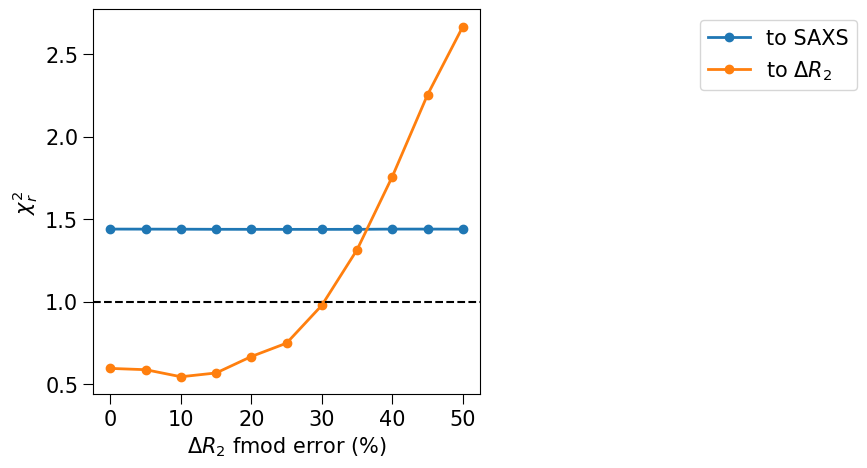

In [13]:
fig = plt.figure(figsize=(5,5))

plt.plot(R2_fmoderrrel_floats*100, chi2_SAXS_vs_R2fmoderrrel, '-o', label='to SAXS', lw=2)
plt.plot(R2_fmoderrrel_floats*100, chi2_rew_vs_R2_err, '-o', label='to $\Delta R_2$', lw=2)

plt.axhline(1.0, ls='--', c='black')

plt.xlabel('$\Delta R_2$ fmod error (%)', fontsize=15)
plt.ylabel('$\chi^2_r$', fontsize=15)
plt.tick_params(colors='black', direction='out', length=7, labelsize=15)
#plt.xticks(rotation=50, ha='right')

plt.legend(fontsize=15, bbox_to_anchor=(2.0, 1.0))


# Final plots for reweighting

In [14]:
R2_err_sel='0.30'
theta_sel_R2_and_SAXS=6
contacts_pkl='../5_analyze_traj/pickles/AB_seq_DBD_hinge_LBD_contacts_CA.pkl'

<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2894491/2722039908.py:16: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(phi_eff_touniform_vs_theta, reweighting_results['chi2'], 'o-', lw=2, ms=8, c=colors[0], label="$\phi_{eff}$ to uniform weights")
/tmp/ipykernel_2894491/2722039908.py:22: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(reweighting_results['phi'], reweighting_results['chi2'], 'o-', lw=2, ms=8, c=colors[1], label="$\phi_{eff}$ to $\Delta$AB prior weights")
/tmp/ipykernel_2894491/2722039908.py:30: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi_{eff}$', fontsize=20)
/tmp/i

0.25794349169752673
1000.0 0.9010678769971056 1.3796471807150008
0.9010678769971056


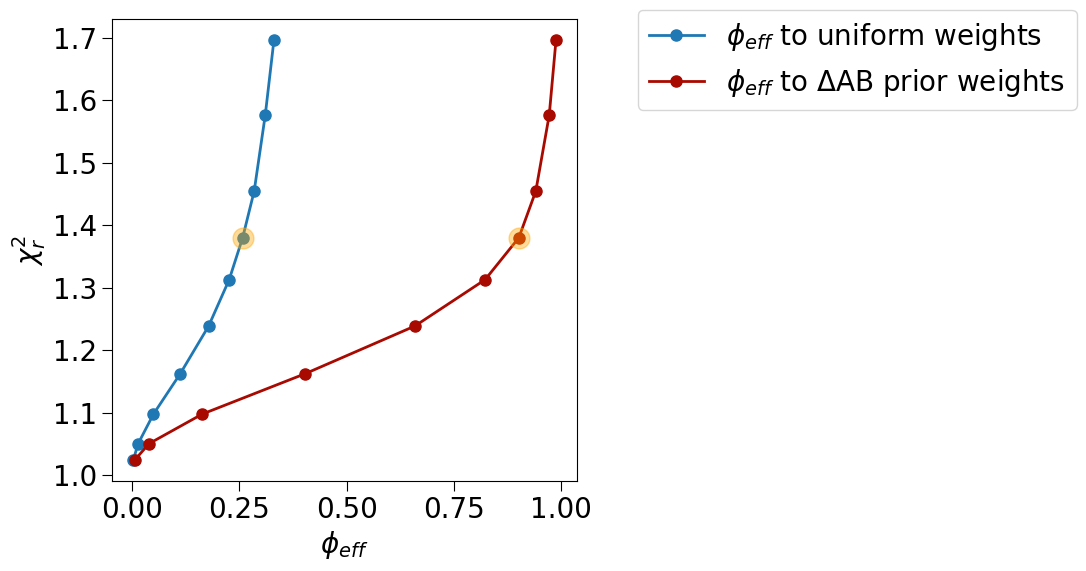

In [15]:
reweighting_results = load_pickle(f'../7_reweighting_FL/R2_err_fmod_{R2_err_sel}/reweighting.pkl')

fig = plt.figure(figsize=(6,6))

#Plot phieff to uniform
weights = load_pickle(f'../7_reweighting_FL/R2_err_fmod_{R2_err_sel}/weights.pkl')
weights_uniform = np.array([1]*len(weights))/len(weights)

phi_eff_touniform_vs_theta = []
for i in range(len(reweighting_results['theta'])): 
    weights_theta = np.array(reweighting_results['weights'][i])
    
    phi_eff_touniform = np.exp(-srel(weights_uniform, weights_theta))
    phi_eff_touniform_vs_theta.append(phi_eff_touniform)

plt.plot(phi_eff_touniform_vs_theta, reweighting_results['chi2'], 'o-', lw=2, ms=8, c=colors[0], label="$\phi_{eff}$ to uniform weights")
plt.plot(phi_eff_touniform_vs_theta[theta_sel_R2_and_SAXS], reweighting_results['chi2'][theta_sel_R2_and_SAXS], 'o', ms=15, alpha=0.4, c='orange')

print(phi_eff_touniform_vs_theta[theta_sel_R2_and_SAXS])

#Plot phieff to dAB prior
plt.plot(reweighting_results['phi'], reweighting_results['chi2'], 'o-', lw=2, ms=8, c=colors[1], label="$\phi_{eff}$ to $\Delta$AB prior weights")

theta_sel_val = reweighting_results['theta'][theta_sel_R2_and_SAXS]
print(theta_sel_val, reweighting_results['phi'][theta_sel_R2_and_SAXS], reweighting_results['chi2'][theta_sel_R2_and_SAXS])
plt.plot(reweighting_results['phi'][theta_sel_R2_and_SAXS], reweighting_results['chi2'][theta_sel_R2_and_SAXS], 'o', ms=15, alpha=0.4, c='orange')

print(reweighting_results['phi'][theta_sel_R2_and_SAXS])

plt.xlabel('$\phi_{eff}$', fontsize=20)
plt.ylabel('$\chi^2_r$', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

plt.legend(fontsize=20, bbox_to_anchor=(1.1, 1.05))

fig.savefig(f'../figures/theta_scan.pdf', bbox_inches='tight', pad_inches=1, dpi=400)


<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894491/2198675134.py:33: SyntaxWarning: invalid escape sequence '\D'
  ax[0].plot(q, SAXS_avg_priorrew_scaleoffset, linewidth=3, label="$\Delta$AB prior", alpha=0.8, color=colors[1])
/tmp/ipykernel_2894491/2198675134.py:39: SyntaxWarning: invalid escape sequence '\D'
  ax[0].text(0.50,0.58, f'Before rew $χ^2_r$: {chi2:.2f} \n$\Delta$AB prior $χ^2_r$: {chi2_priorrew:.2f} \nAfter rew $χ^2_r$: {chi2_rew:.2f}', fontsize=18, transform=ax[0].transAxes)


10.425750763617039 [0.0427275  0.04259473 0.04246193 ... 0.00011921 0.00011922 0.00011923] 1.4381943972187112


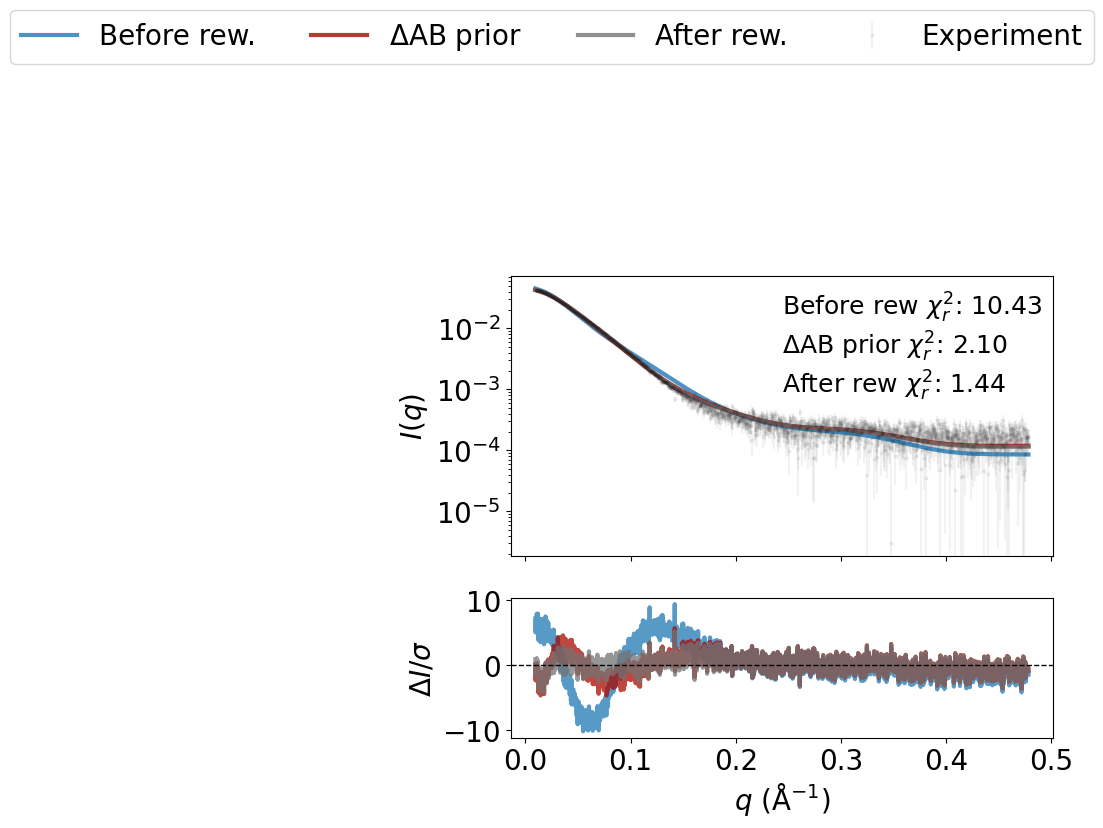

In [16]:
SAXS_avg = np.average(SAXS, axis=0)

weights_prior = load_pickle('../6_reweighting_dAB/weights.pkl')
weights = load_pickle(f'../7_reweighting_FL/R2_err_fmod_{R2_err_sel}/weights.pkl')

SAXS_avg = np.average(SAXS, axis=0)
SAXS_avg_priorrew = np.average(SAXS, axis=0, weights=weights_prior)
SAXS_avg_rew = np.average(SAXS, axis=0, weights=weights)

q, I_exp, err_exp = load_exp_SAXS('../7_reweighting_FL/PPARg_lowsalt_SAXSexpt.dat')
q *= 0.1

SAXS_avg_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_avg, I_exp, err_exp)
SAXS_avg_priorrew_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_avg_priorrew, I_exp, err_exp)
SAXS_avg_rew_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_avg_rew, I_exp, err_exp)

chi2 = get_chi2(SAXS_avg_scaleoffset, I_exp, err_exp)
chi2_priorrew = get_chi2(SAXS_avg_priorrew_scaleoffset, I_exp, err_exp)
chi2_rew = get_chi2(SAXS_avg_rew_scaleoffset, I_exp, err_exp)
print(chi2, SAXS_avg_priorrew_scaleoffset, chi2_rew)

residuals = (SAXS_avg_scaleoffset-I_exp)/err_exp
residuals_priorrew = (SAXS_avg_priorrew_scaleoffset-I_exp)/err_exp
residuals_rew = (SAXS_avg_rew_scaleoffset-I_exp)/err_exp

#SAXS figure
fig, ax = plt.subplots(figsize = (7,6), nrows=2, sharex='col', sharey='row', gridspec_kw={'height_ratios': [4, 2]})

#ax[0].set_title(f'Full-length SAXS', fontsize=20)

ax[0].errorbar(q, I_exp, yerr=err_exp, fmt='o', markersize=2, color='black', alpha=0.05, label='Experiment')
ax[0].plot(q, SAXS_avg_scaleoffset, linewidth=3, label="Before rew.", alpha=0.8, color=colors[0])
ax[0].plot(q, SAXS_avg_priorrew_scaleoffset, linewidth=3, label="$\Delta$AB prior", alpha=0.8, color=colors[1])
ax[0].plot(q, SAXS_avg_rew_scaleoffset, linewidth=3, label="After rew.", alpha=0.8, color=colors[2])

ax[0].semilogy()
ax[0].set_ylabel('$I(q)$', fontsize=20)
ax[0].legend(fontsize=20, ncol=6, bbox_to_anchor=(1.1, 2.0))
ax[0].text(0.50,0.58, f'Before rew $χ^2_r$: {chi2:.2f} \n$\Delta$AB prior $χ^2_r$: {chi2_priorrew:.2f} \nAfter rew $χ^2_r$: {chi2_rew:.2f}', fontsize=18, transform=ax[0].transAxes)

for j in range(len(ax)):
    ax[j].tick_params(axis='both', which='major', labelsize=20)

ax[1].plot(q, residuals, linewidth=3, color= colors[0], alpha=0.75)
ax[1].plot(q, residuals_priorrew, linewidth=3, color= colors[1], alpha=0.75)
ax[1].plot(q, residuals_rew, linewidth=3, color= colors[2], alpha=0.75)

ax[1].set_ylabel('$ΔI/σ$', fontsize=20)
ax[1].set_xlabel('$q$ (Å$^{-1}$)', fontsize=20)
ax[1].axhline(0, ls='--', linewidth=1, color='black')

fig.savefig('../figures/SAXS.pdf', bbox_inches='tight', pad_inches=1, dpi=400)

In [17]:
dR2_calc = load_sim_SAXS('../7_reweighting_FL/AB_seq_DBD_hinge_LBD_contacts_CA_allresis_R2diff_BMEcalc.dat')

dR2_avg = np.average(dR2_calc , axis=0)
dR2_avg_priorrew = np.average(dR2_calc, axis=0, weights=weights_prior)
dR2_avg_rew = np.average(dR2_calc, axis=0, weights=weights)

residue, dR2_exp, dR2_err_exp = load_exp_SAXS('../7_reweighting_FL/AB_seq_DBD_hinge_LBD_contacts_CA_allresis_R2diff_BMEexpt.dat')

dR2_avg_scaleoffset, slope, intercept, r_value = fit_scale_offset(dR2_avg, dR2_exp, dR2_err_exp)
dR2_avg_priorrew_scaleoffset, slope, intercept, r_value = fit_scale_offset(dR2_avg_priorrew, dR2_exp, dR2_err_exp)
dR2_avg_rew_scaleoffset, slope, intercept, r_value = fit_scale_offset(dR2_avg_rew, dR2_exp, dR2_err_exp)

chi2 = get_chi2(dR2_avg_scaleoffset, dR2_exp, dR2_err_exp)
chi2_priorrew = get_chi2(dR2_avg_priorrew_scaleoffset, dR2_exp, dR2_err_exp)
chi2_rew = get_chi2(dR2_avg_rew_scaleoffset, dR2_exp, dR2_err_exp)
print(chi2, chi2_priorrew, chi2_rew)

7.868562217900524 7.921033423561921 0.9779985947779585


<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894491/528912578.py:5: SyntaxWarning: invalid escape sequence '\D'
  ax.plot(residue, dR2_avg_priorrew_scaleoffset, '-o', alpha=0.8, label=f'$\Delta$AB prior ($χ^2_r$: {chi2_priorrew:.2f})', c=colors[1])
/tmp/ipykernel_2894491/528912578.py:10: SyntaxWarning: invalid escape sequence '\D'
  ax2.plot(residue, dR2_avg_priorrew_scaleoffset, '-o', alpha=0.8, label=f'$\Delta$AB prior ($χ^2_r$: {chi2_priorrew:.2f})', c=colors[1])
/tmp/ipykernel_2894491/528912578.py:20: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel('$\Delta R_2$ (s$^{-1}$) or\n⟨Contacts⟩ (A.U.)', fontsize=20)


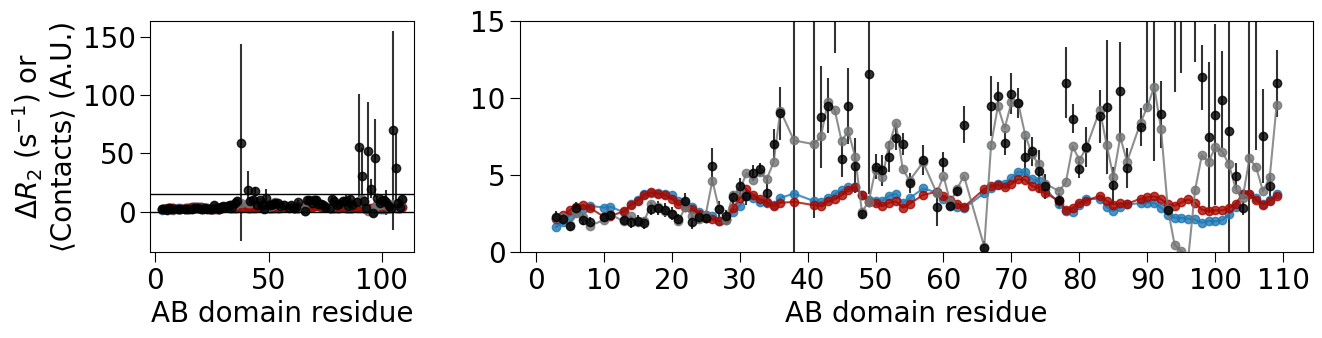

In [18]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [2, 6]})

ax.errorbar(residue, dR2_exp, yerr=dR2_err_exp, fmt='o', c='black', alpha=0.8)
ax.plot(residue, dR2_avg_scaleoffset, '-o', alpha=0.8, label=f'Before rew. ($χ^2_r$: {chi2:.2f})', c=colors[0])
ax.plot(residue, dR2_avg_priorrew_scaleoffset, '-o', alpha=0.8, label=f'$\Delta$AB prior ($χ^2_r$: {chi2_priorrew:.2f})', c=colors[1])
ax.plot(residue,dR2_avg_rew_scaleoffset, '-o', alpha=0.8, label=f'After rew. ($χ^2_r$: {chi2_rew:.2f})', c=colors[2])

ax2.errorbar(residue, dR2_exp, yerr=dR2_err_exp, fmt='o', c='black', alpha=0.8)
ax2.plot(residue, dR2_avg_scaleoffset, '-o', alpha=0.8, label=f'Before rew. ($χ^2_r$: {chi2:.2f})', c=colors[0])
ax2.plot(residue, dR2_avg_priorrew_scaleoffset, '-o', alpha=0.8, label=f'$\Delta$AB prior ($χ^2_r$: {chi2_priorrew:.2f})', c=colors[1])
ax2.plot(residue,dR2_avg_rew_scaleoffset, '-o', alpha=0.8, label=f'After rew. ($χ^2_r$: {chi2_rew:.2f})', c=colors[2])

# zoom-in / limit the view to different portions of the data
ax2.set_ylim(0,15)  # outliers only
ax.axhline(0, color='black', lw=1)
ax.axhline(15, color='black', lw=1)

ax.set_xlabel('AB domain residue', fontsize=20)
ax2.set_xlabel('AB domain residue', fontsize=20)
ax.set_ylabel('$\Delta R_2$ (s$^{-1}$) or\n⟨Contacts⟩ (A.U.)', fontsize=20)
ax.tick_params(colors='black', direction='out', length=7, labelsize=20)
ax2.tick_params(colors='black', direction='out', length=7, labelsize=20)
ax2.set_xticks(range(0, 120, 10))


fig.savefig('../figures/dR2_vs_residue.pdf', bbox_inches='tight', pad_inches=1, dpi=400)

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894491/1799624990.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.errorbar(dR2_exp, dR2_avg_priorrew_scaleoffset, xerr=dR2_err_exp, fmt='o', label=f'$\Delta$AB prior ($χ^2_r$: {chi2_priorrew:.2f}', c=colors[1])
/tmp/ipykernel_2894491/1799624990.py:11: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta R_2$ (s$^{-1}$)', fontsize=20)


(0.0, 20.0)

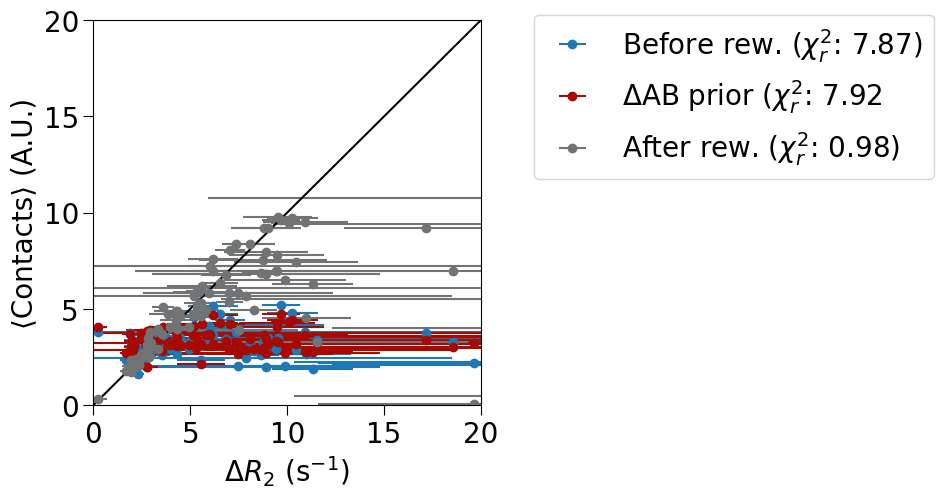

In [19]:
fig = plt.figure(figsize=(5,5))

plt.errorbar(dR2_exp, dR2_avg_scaleoffset, xerr=dR2_err_exp, fmt='o', label=f'Before rew. ($χ^2_r$: {chi2:.2f})', c=colors[0])
plt.errorbar(dR2_exp, dR2_avg_priorrew_scaleoffset, xerr=dR2_err_exp, fmt='o', label=f'$\Delta$AB prior ($χ^2_r$: {chi2_priorrew:.2f}', c=colors[1])
plt.errorbar(dR2_exp, dR2_avg_rew_scaleoffset, xerr=dR2_err_exp, fmt='o', label=f'After rew. ($χ^2_r$: {chi2_rew:.2f})', c=colors[2])

plt.plot([0,100], [0,100], c='black')

plt.legend(fontsize=20, bbox_to_anchor=(1.1, 1.05))

plt.xlabel('$\Delta R_2$ (s$^{-1}$)', fontsize=20)
plt.ylabel('⟨Contacts⟩ (A.U.)', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

max_lim = np.amax(np.concatenate((dR2_avg_scaleoffset, dR2_avg_rew_scaleoffset, dR2_exp)))
max_lim *= 1.1

#plt.xlim(0,max_lim)
#plt.ylim(0,max_lim)

plt.xlim(0,20)
plt.ylim(0,20)


<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894491/1240396106.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(AB_resis+1, contacts_avg_priorrew, '-', lw=3, alpha=0.8, label='$\Delta$AB prior', c=colors[1])


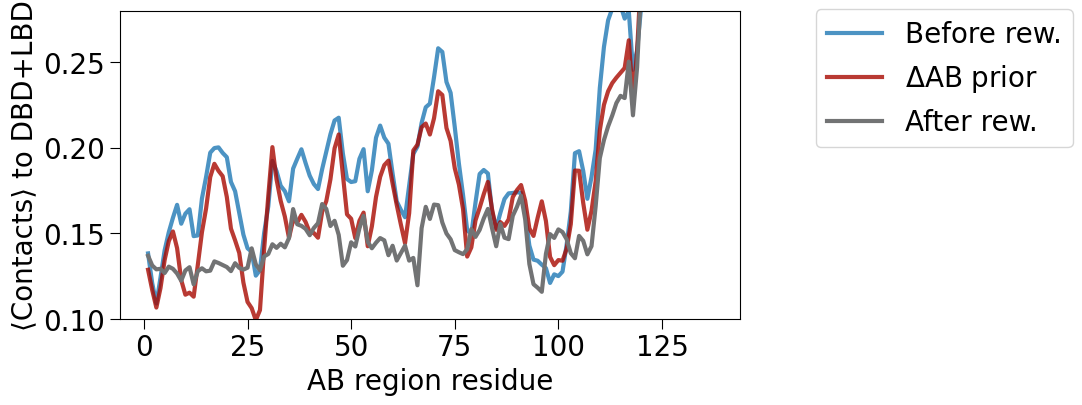

In [20]:
contacts = load_pickle(contacts_pkl)

contacts_avg = np.average(contacts, axis=1)
contacts_avg_priorrew = np.average(contacts, axis=1, weights=weights_prior)
contacts_avg_rew = np.average(contacts, axis=1, weights=weights)

fig = plt.figure(figsize=(8,4))

plt.plot(AB_resis+1, contacts_avg, '-', lw=3, alpha=0.8, label='Before rew.', c=colors[0])
plt.plot(AB_resis+1, contacts_avg_priorrew, '-', lw=3, alpha=0.8, label='$\Delta$AB prior', c=colors[1])
plt.plot(AB_resis+1, contacts_avg_rew, '-', lw=3, alpha=1.0, label='After rew.', c=colors[2])

plt.xlabel('AB region residue', fontsize=20)
plt.ylabel('⟨Contacts⟩ to DBD+LBD', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

#plt.ylim(0.08,0.3)
plt.ylim(0.10,0.28)

plt.legend(fontsize=20, bbox_to_anchor=(1.1, 1.05))

# Ensemble analysis

In [21]:
weights_prior = load_pickle('../6_reweighting_dAB/weights.pkl')
weights = load_pickle(f'../7_reweighting_FL/R2_err_fmod_{R2_err_sel}/weights.pkl')

## DBD-LBD COMdist

Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 40



/projects/prism/people/hzr104/software/BLOCKING_OLD/MonoCV/block.py:59: RuntimeWarning: invalid value encountered in scalar divide
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


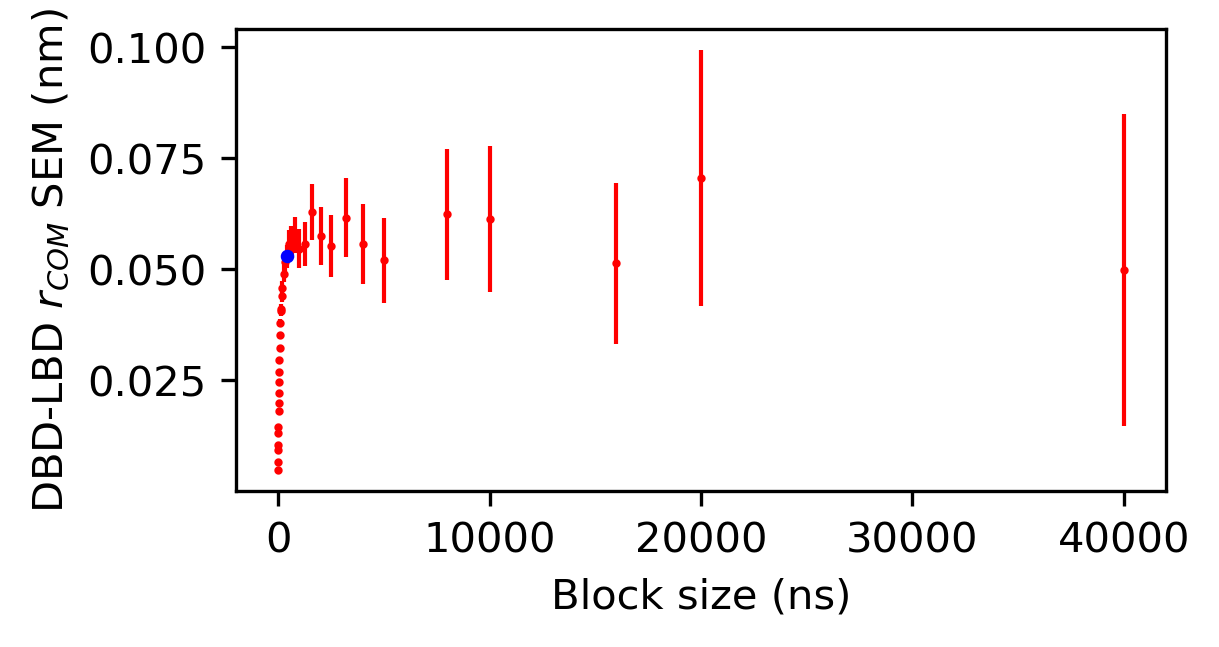

In [22]:
mdtraj = md.load(traj, top=top)

DBD_slice = mdtraj.atom_slice(DBD_atoms)
LBD_slice = mdtraj.atom_slice(LBD_atoms)

DBD_COM = md.compute_center_of_mass(DBD_slice)
LBD_COM = md.compute_center_of_mass(LBD_slice)

DBD_LDB_COMdist = np.linalg.norm(DBD_COM-LBD_COM, axis=1)

#Block error analysis
corr_len, err, blocks_stat = block_err_analysis(DBD_LDB_COMdist, errmethod)
plt.fig = plt.figure(figsize=(4, 2), dpi=300, facecolor='w')
plt.xlabel('Block size (ns)')
plt.ylabel('DBD-LBD $r_{COM}$ SEM (nm)')
plt.errorbar(blocks_stat[...,0],blocks_stat[...,1],blocks_stat[...,2],fmt='ro',ms=1,elinewidth=1)
plt.scatter(corr_len,err,c='blue',zorder=300,s=5)

save_pickle('../5_analyze_traj/pickles/DBD_LDB_COMdist.pkl', DBD_LDB_COMdist)

<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894491/3791078631.py:19: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[1], label="$\Delta$AB prior")


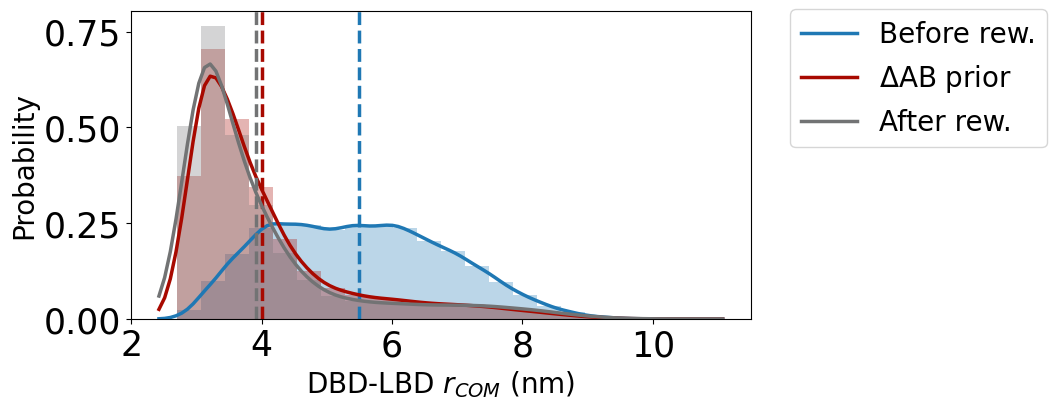

In [23]:
fig = plt.figure(figsize=(8,4))

#KDE
kde_x = np.linspace( np.amin(DBD_LDB_COMdist)*0.9, np.amax(DBD_LDB_COMdist)*1.1, num = 100 )
kde_y = stats.gaussian_kde(DBD_LDB_COMdist, bw_method = "silverman").evaluate(kde_x)

plt.hist(DBD_LDB_COMdist, density=True, color=colors[0], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[0], label='Before rew.')

plt.axvline(x=np.average(DBD_LDB_COMdist), ls='--', linewidth=2.5, alpha=1, color=colors[0])



#KDE
kde_x = np.linspace( np.amin(DBD_LDB_COMdist)*0.9, np.amax(DBD_LDB_COMdist)*1.1, num = 100 )
kde_y = stats.gaussian_kde(DBD_LDB_COMdist, bw_method = "silverman", weights=weights_prior).evaluate(kde_x)

plt.hist(DBD_LDB_COMdist, weights=weights_prior, density=True, color=colors[1], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[1], label="$\Delta$AB prior")

plt.axvline(x=np.average(DBD_LDB_COMdist, weights=weights_prior), ls='--', linewidth=2.5, alpha=1, color=colors[1])



#KDE
kde_x = np.linspace( np.amin(DBD_LDB_COMdist)*0.9, np.amax(DBD_LDB_COMdist)*1.1, num = 100 )
kde_y = stats.gaussian_kde(DBD_LDB_COMdist, bw_method = "silverman", weights=weights).evaluate(kde_x)

plt.hist(DBD_LDB_COMdist, weights=weights, density=True, color=colors[2], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[2], label='After rew.')

plt.axvline(x=np.average(DBD_LDB_COMdist, weights=weights), ls='--', linewidth=2.5, alpha=1, color=colors[2])




plt.tick_params(axis='both', which='major', labelsize=25)
plt.legend(fontsize=20, bbox_to_anchor=(1.5, 1.05))

plt.xlabel('DBD-LBD $r_{COM}$ (nm)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

fig.savefig("../figures/DBD_LBD_COMdist_histogram.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

## Rg

Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 40



/projects/prism/people/hzr104/software/BLOCKING_OLD/MonoCV/block.py:59: RuntimeWarning: invalid value encountered in scalar divide
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


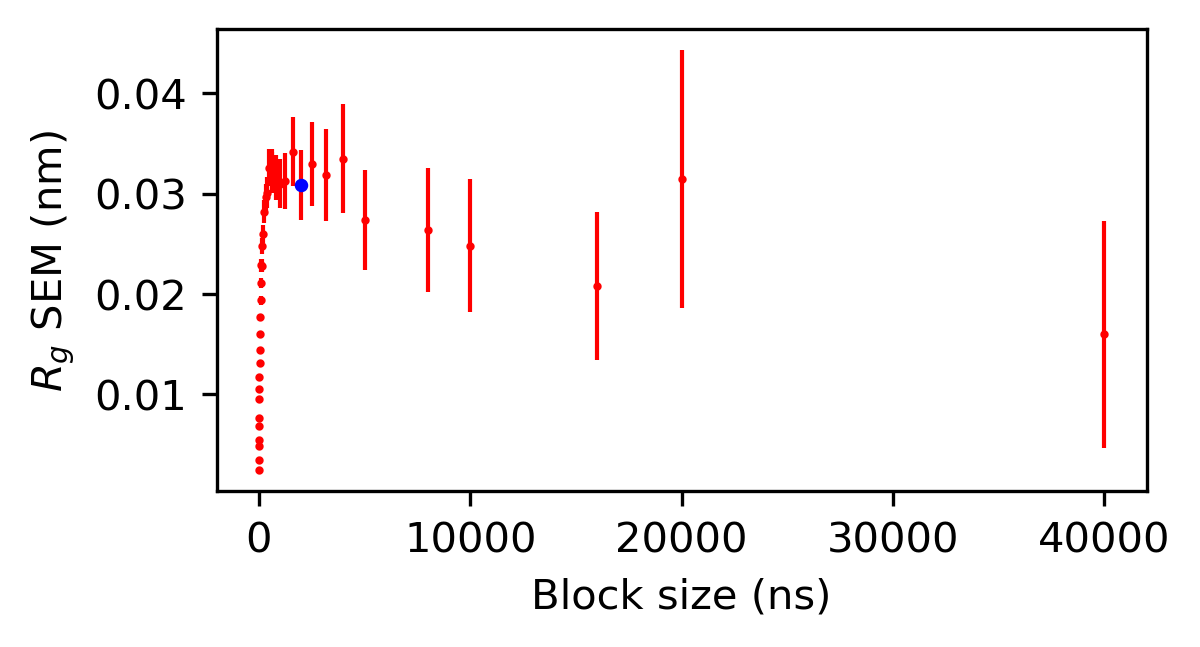

In [24]:
time, Rg1 = np.genfromtxt('../5_analyze_traj/calc_Rg/Rg_gyrate_free_rep1.xvg', usecols=(0,1), skip_header=27, unpack=True)
time, Rg2 = np.genfromtxt('../5_analyze_traj/calc_Rg/Rg_gyrate_free_rep2.xvg', usecols=(0,1), skip_header=27, unpack=True)

Rg = [*Rg1, *Rg2]

#Block error analysis
corr_len, err, blocks_stat = block_err_analysis(Rg, errmethod)
plt.fig = plt.figure(figsize=(4, 2), dpi=300, facecolor='w')
plt.xlabel('Block size (ns)')
plt.ylabel('$R_g$ SEM (nm)')
plt.errorbar(blocks_stat[...,0],blocks_stat[...,1],blocks_stat[...,2],fmt='ro',ms=1,elinewidth=1)
plt.scatter(corr_len,err,c='blue',zorder=300,s=5)


<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894491/1742202026.py:19: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[1], label='$\Delta$AB prior')


Text(0, 0.5, 'Probability')

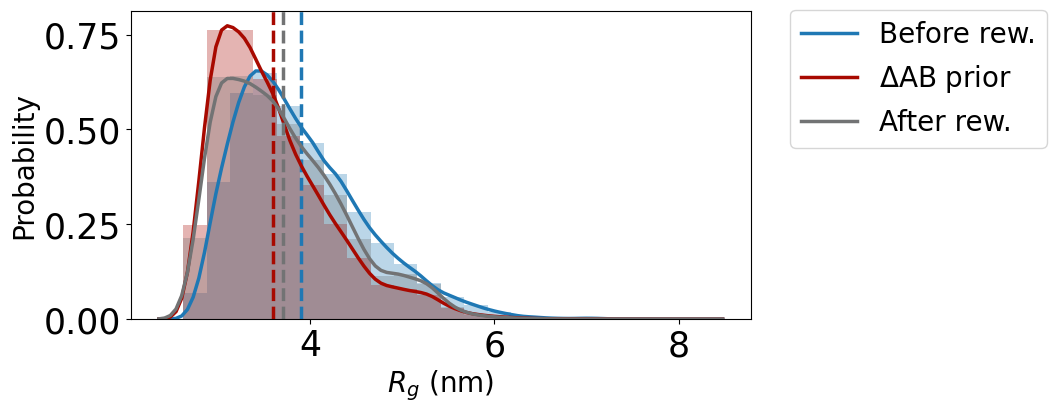

In [25]:
fig = plt.figure(figsize=(8,4))

#KDE
kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg, bw_method = "silverman").evaluate(kde_x)

plt.hist(Rg, density=True, color=colors[0], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[0], label='Before rew.')

plt.axvline(x=np.average(Rg), ls='--', linewidth=2.5, alpha=1, color=colors[0])



#KDE
kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg, bw_method = "silverman", weights=weights_prior).evaluate(kde_x)

plt.hist(Rg, weights=weights_prior, density=True, color=colors[1], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[1], label='$\Delta$AB prior')

plt.axvline(x=np.average(Rg, weights=weights_prior), ls='--', linewidth=2.5, alpha=1, color=colors[1])



#KDE
kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg, bw_method = "silverman", weights=weights).evaluate(kde_x)

plt.hist(Rg, weights=weights, density=True, color=colors[2], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[2], label='After rew.')

plt.axvline(x=np.average(Rg, weights=weights), ls='--', linewidth=2.5, alpha=1, color=colors[2])



plt.legend(fontsize=20, bbox_to_anchor=(1.5, 1.05))
plt.tick_params(axis='both', which='major', labelsize=25)

plt.xlabel('$R_g$ (nm)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

## Rg IDR only

Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 40



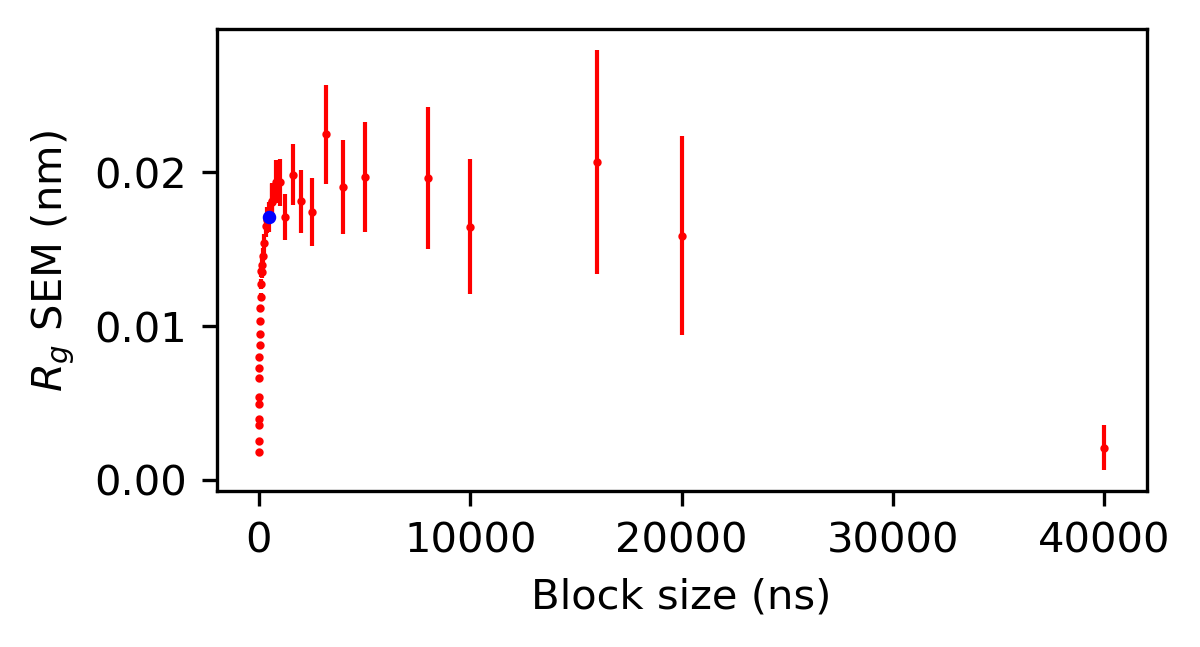

In [26]:
time, Rg1 = np.genfromtxt('../5_analyze_traj/calc_Rg/Rg_gyrate_IDRonly_free_rep1.xvg', usecols=(0,1), skip_header=27, unpack=True)
time, Rg2 = np.genfromtxt('../5_analyze_traj/calc_Rg/Rg_gyrate_IDRonly_free_rep2.xvg', usecols=(0,1), skip_header=27, unpack=True)

Rg = [*Rg1, *Rg2]

#Block error analysis
corr_len, err, blocks_stat = block_err_analysis(Rg, errmethod)
plt.fig = plt.figure(figsize=(4, 2), dpi=300, facecolor='w')
plt.xlabel('Block size (ns)')
plt.ylabel('$R_g$ SEM (nm)')
plt.errorbar(blocks_stat[...,0],blocks_stat[...,1],blocks_stat[...,2],fmt='ro',ms=1,elinewidth=1)
plt.scatter(corr_len,err,c='blue',zorder=300,s=5)


<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894491/4250169893.py:19: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[1], label='$\Delta$AB prior')


Text(0, 0.5, 'Probability')

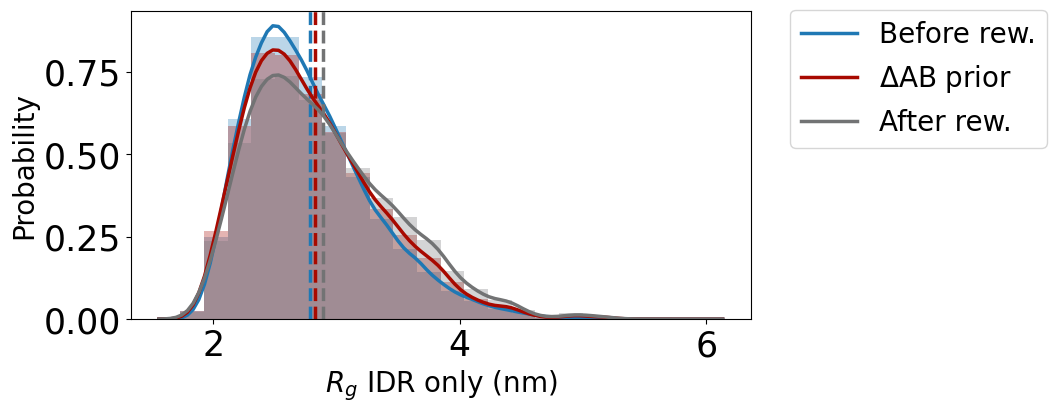

In [27]:
fig = plt.figure(figsize=(8,4))

#KDE
kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg, bw_method = "silverman").evaluate(kde_x)

plt.hist(Rg, density=True, color=colors[0], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[0], label='Before rew.')

plt.axvline(x=np.average(Rg), ls='--', linewidth=2.5, alpha=1, color=colors[0])



#KDE
kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg, bw_method = "silverman", weights=weights_prior).evaluate(kde_x)

plt.hist(Rg, weights=weights_prior, density=True, color=colors[1], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[1], label='$\Delta$AB prior')

plt.axvline(x=np.average(Rg, weights=weights_prior), ls='--', linewidth=2.5, alpha=1, color=colors[1])



#KDE
kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg, bw_method = "silverman", weights=weights).evaluate(kde_x)

plt.hist(Rg, weights=weights, density=True, color=colors[2], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[2], label='After rew.')

plt.axvline(x=np.average(Rg, weights=weights), ls='--', linewidth=2.5, alpha=1, color=colors[2])



plt.legend(fontsize=20, bbox_to_anchor=(1.5, 1.05))
plt.tick_params(axis='both', which='major', labelsize=25)

plt.xlabel('$R_g$ IDR only (nm)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

# AB only CALVADOS simulations analysis

<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2894491/224712187.py:12: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi_{eff}$', fontsize=20)
/tmp/ipykernel_2894491/224712187.py:13: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('$\chi^2_r$', fontsize=20)


14.38449888287663 0.9476218025870868 1.028334256456542


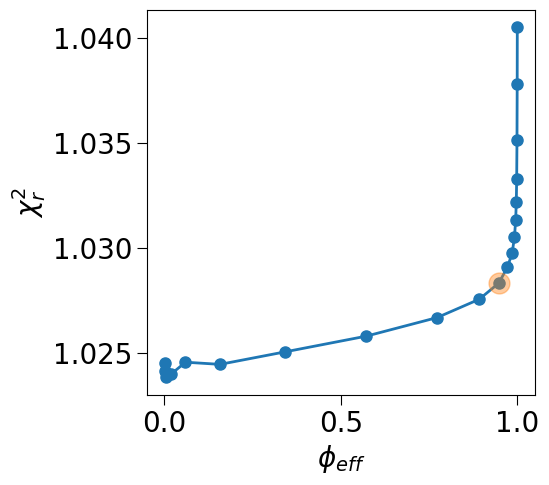

In [28]:
theta_sel_AB_SAXS=10

reweighting_results_AB = load_pickle('../../PPARg_AB/4_reweighting/reweighting.pkl')
fig = plt.figure(figsize=(5,5))

plt.plot(reweighting_results_AB['phi'], reweighting_results_AB['chi2'], 'o-', lw=2, ms=8)

theta_sel_val = reweighting_results_AB['theta'][theta_sel_AB_SAXS]
print(theta_sel_val, reweighting_results_AB['phi'][theta_sel_AB_SAXS], reweighting_results_AB['chi2'][theta_sel_AB_SAXS])
plt.plot(reweighting_results_AB['phi'][theta_sel_AB_SAXS], reweighting_results_AB['chi2'][theta_sel_AB_SAXS], 'o', ms=15, alpha=0.4, label=f'{theta_sel_val}')

plt.xlabel('$\phi_{eff}$', fontsize=20)
plt.ylabel('$\chi^2_r$', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

fig.savefig(f"../figures/AB_alone/SAXS_thetascan.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

save_pickle('../../PPARg_AB/4_reweighting/weights.pkl', reweighting_results_AB['weights'][theta_sel_AB_SAXS])

In [29]:
#Compare with CALVADOS on AB alone
weights_AB = load_pickle('../../PPARg_AB/4_reweighting/weights.pkl')[10:]
SAXS_AB = load_sim_SAXS('../../PPARg_AB/4_reweighting/calc_SAXS.dat')[10:] 
#SKIPPING FIRST 10 FRAMES EVEN THOUGH THEY WERE USED IN REWEIGHTING

chi2 before: 1.0470211721282319, chi2 after: 1.0283666110980483


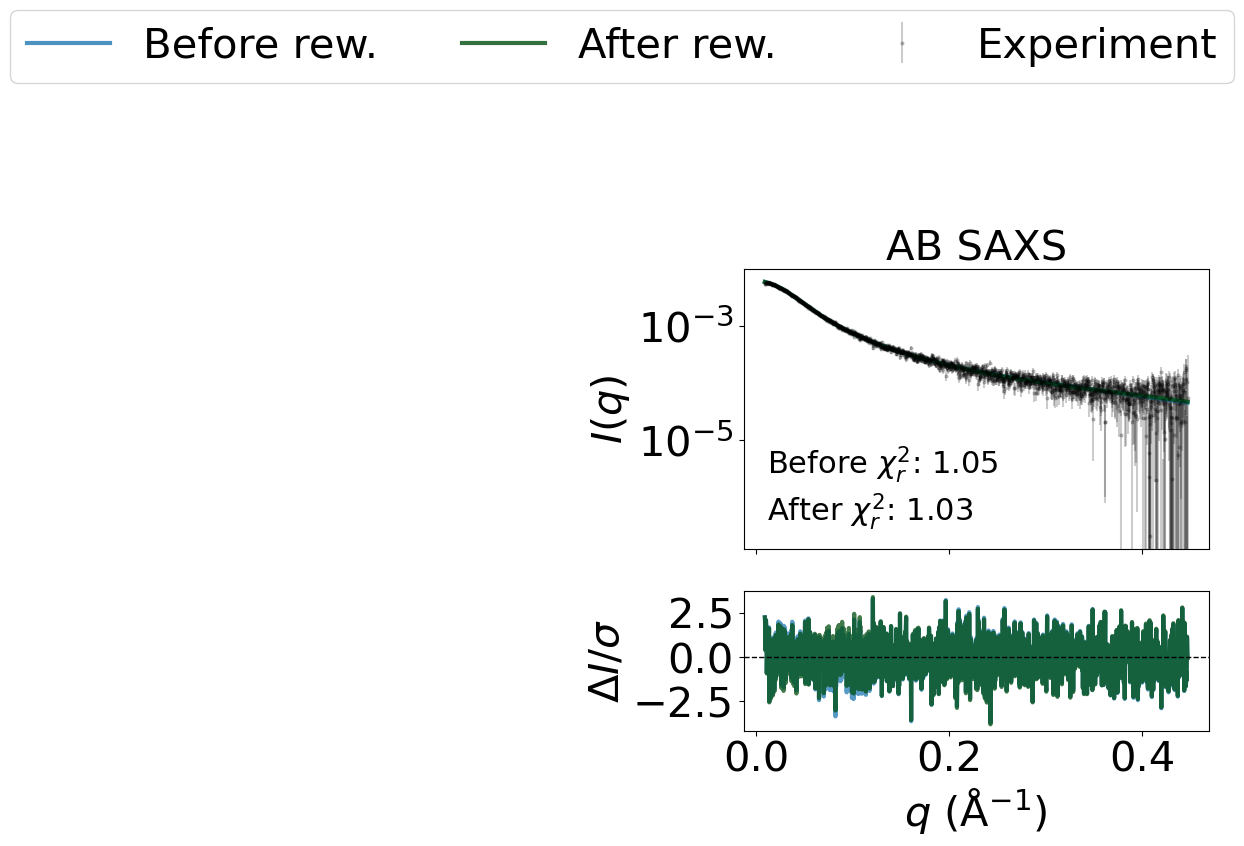

In [30]:
SAXS_AB_avg = np.average(SAXS_AB, axis=0)
SAXS_AB_avg_rew = np.average(SAXS_AB, axis=0, weights=weights_AB)

q, I_exp, err_exp = load_exp_SAXS('../../PPARg_AB/4_reweighting/PPARg_ABonly_SAXSexpt.dat')
q *= 0.1

SAXS_AB_avg_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_AB_avg, I_exp, err_exp)
SAXS_AB_avg_rew_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_AB_avg_rew, I_exp, err_exp)

chi2 = get_chi2(SAXS_AB_avg_scaleoffset, I_exp, err_exp)
chi2_rew = get_chi2(SAXS_AB_avg_rew_scaleoffset, I_exp, err_exp)

print(f'chi2 before: {chi2}, chi2 after: {chi2_rew}')

residuals = (SAXS_AB_avg_scaleoffset-I_exp)/err_exp
residuals_rew = (SAXS_AB_avg_rew_scaleoffset-I_exp)/err_exp

#SAXS figure
fig, ax = plt.subplots(figsize = (6,6), nrows=2, sharex='col', sharey='row', gridspec_kw={'height_ratios': [4, 2]})

ax[0].set_title('AB SAXS', fontsize=30)

ax[0].errorbar(q, I_exp, yerr=err_exp, fmt='o', markersize=2, color='black', alpha=0.2, label='Experiment')
ax[0].plot(q, SAXS_AB_avg_scaleoffset, linewidth=3, label="Before rew.", alpha=0.8, color=colors[3])
ax[0].plot(q, SAXS_AB_avg_rew_scaleoffset, linewidth=3, label="After rew.", alpha=0.8, color=colors[4])

ax[0].semilogy()
ax[0].set_ylabel('$I(q)$', fontsize=30)
ax[0].legend(fontsize=30, ncol=6, bbox_to_anchor=(1.1, 2.0))
ax[0].text(0.05,0.10, f'Before $χ^2_r$: {chi2:.2f} \nAfter $χ^2_r$: {chi2_rew:.2f}', fontsize=22, transform=ax[0].transAxes)

for j in range(len(ax)):
    ax[j].tick_params(axis='both', which='major', labelsize=30)

ax[1].plot(q, residuals, linewidth=3, color= colors[3], alpha=0.75)
ax[1].plot(q, residuals_rew, linewidth=3, color= colors[4], alpha=0.75)

ax[1].set_ylabel('$ΔI/σ$', fontsize=30)
ax[1].set_xlabel('$q$ (Å$^{-1}$)', fontsize=30)
ax[1].axhline(0, ls='--', linewidth=1, color='black')

fig.savefig("../figures/AB_alone/SAXS_rew.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

Possible blocks transformations: 20
 no lenght correction needed

3.5941262589406797 +- 0.01703717714619581


/projects/prism/people/hzr104/software/BLOCKING_OLD/MonoCV/block.py:59: RuntimeWarning: invalid value encountered in scalar divide
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


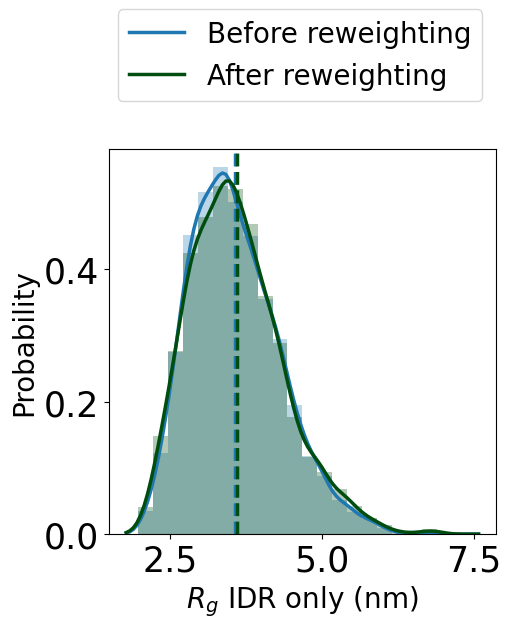

In [31]:
Rg_AB = np.load('../../PPARg_AB/trajectory_CG/rg.npy')

fig = plt.figure(figsize=(5,5))

#KDE
kde_x = np.linspace( np.amin(Rg_AB)*0.9, np.amax(Rg_AB)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg_AB, bw_method = "silverman").evaluate(kde_x)

plt.hist(Rg_AB, density=True, color=colors[3], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[3], label='Before reweighting')

plt.axvline(x=np.average(Rg_AB), ls='--', linewidth=2.5, alpha=1, color=colors[3])

#KDE
kde_x = np.linspace( np.amin(Rg_AB)*0.9, np.amax(Rg_AB)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg_AB, bw_method = "silverman", weights=weights_AB).evaluate(kde_x)

plt.hist(Rg_AB, weights=weights_AB, density=True, color=colors[4], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[4], label='After reweighting')

plt.axvline(x=np.average(Rg_AB, weights=weights_AB), ls='--', linewidth=2.5, alpha=1, color=colors[4])


plt.legend(fontsize=20, bbox_to_anchor=(1.0, 1.4))
plt.tick_params(axis='both', which='major', labelsize=25)

plt.xlabel('$R_g$ IDR only (nm)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

fig.savefig("../figures/AB_alone/Rg_histogram_beforeafterrew.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

corr_len, err_Rg_AB, blocks_stat = block_err_analysis(Rg_AB, errmethod)

print(f'{np.average(Rg_AB, weights=weights_AB)} +- {err_Rg_AB}')

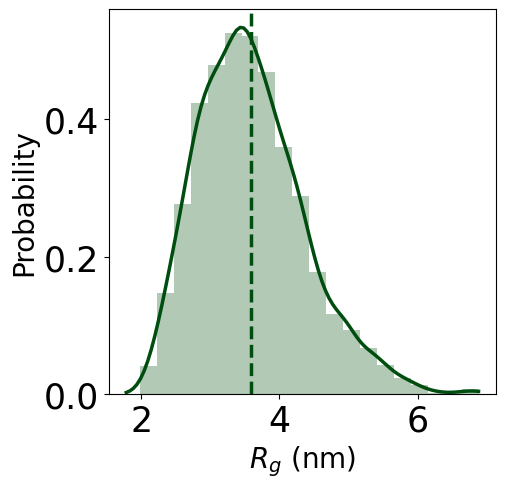

In [32]:
fig = plt.figure(figsize=(5,5))

#KDE
kde_x = np.linspace( np.amin(Rg_AB)*0.9, np.amax(Rg_AB), num = 100 )
kde_y = stats.gaussian_kde(Rg_AB, bw_method = "silverman", weights=weights_AB).evaluate(kde_x)

plt.hist(Rg_AB, weights=weights_AB, density=True, color=colors[4], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[4], label='After reweighting')

plt.axvline(x=np.average(Rg_AB, weights=weights_AB), ls='--', linewidth=2.5, alpha=1, color=colors[4])

plt.tick_params(axis='both', which='major', labelsize=25)

plt.xlabel('$R_g$ (nm)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

fig.savefig("../figures/AB_alone/Rg_histogram.pdf", bbox_inches='tight', pad_inches=1, dpi=400)


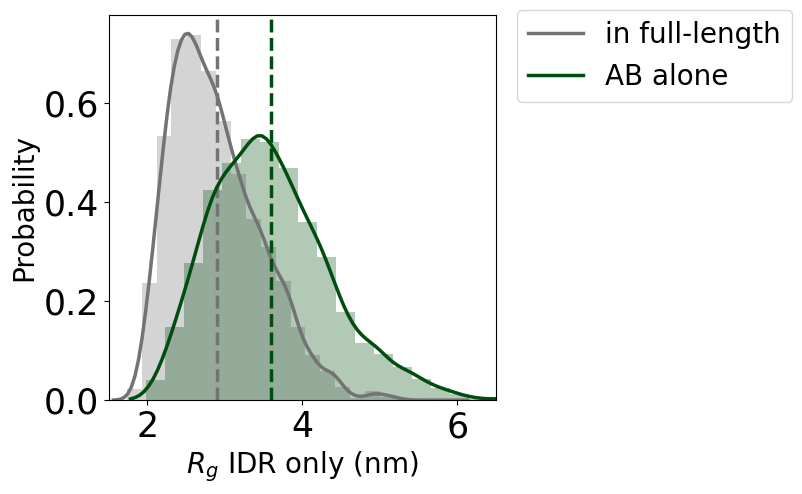

In [33]:
#Plot Rg
time, Rg1 = np.genfromtxt('../5_analyze_traj/calc_Rg/Rg_gyrate_IDRonly_free_rep1.xvg', usecols=(0,1), skip_header=27, unpack=True)
time, Rg2 = np.genfromtxt('../5_analyze_traj/calc_Rg/Rg_gyrate_IDRonly_free_rep2.xvg', usecols=(0,1), skip_header=27, unpack=True)
Rg = [*Rg1, *Rg2]

fig = plt.figure(figsize=(5,5))

#KDE
kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg, bw_method = "silverman", weights=weights).evaluate(kde_x)

plt.hist(Rg, weights=weights, density=True, color=colors[2], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[2], label='in full-length')

plt.axvline(x=np.average(Rg, weights=weights), ls='--', linewidth=2.5, alpha=1, color=colors[2])

#KDE
kde_x = np.linspace( np.amin(Rg_AB)*0.9, np.amax(Rg_AB)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg_AB, bw_method = "silverman", weights=weights_AB).evaluate(kde_x)

plt.hist(Rg_AB, weights=weights_AB, density=True, color=colors[4], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[4], label='AB alone')

plt.axvline(x=np.average(Rg_AB, weights=weights_AB), ls='--', linewidth=2.5, alpha=1, color=colors[4])


#plt.legend(fontsize=20, bbox_to_anchor=(1.6, 1.05))
plt.legend(fontsize=20, bbox_to_anchor=(1.8, 1.05))

plt.tick_params(axis='both', which='major', labelsize=25)

plt.xlabel('$R_g$ IDR only (nm)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

plt.xlim(1.5,6.5)

fig.savefig(f"../figures/AB_alone/Rg_IDRfulllength_IDRalone_histogram.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

## Contacts AB sequence (DBD and LBD together)

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894491/2938003133.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(AB_resis+1, contacts_avg_priorrew, '-', lw=3, alpha=0.8, label='$\Delta$AB prior', c=colors[1])


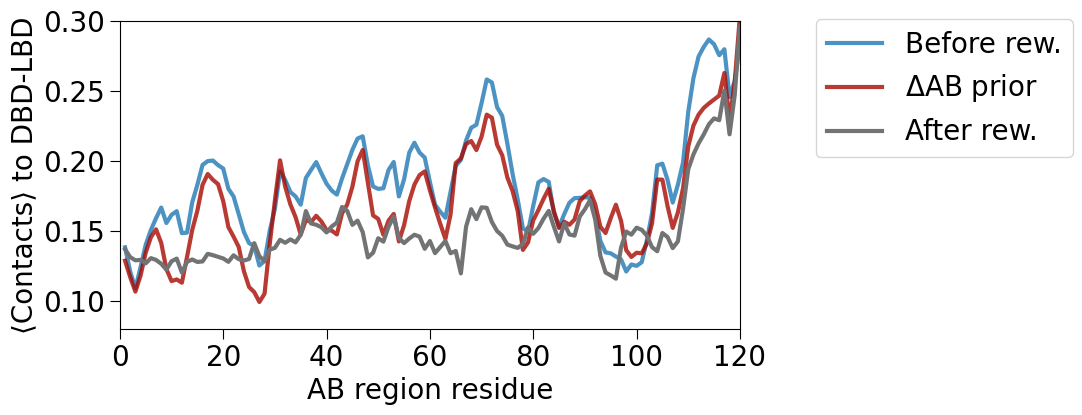

In [34]:
contacts = load_pickle('../5_analyze_traj/pickles/AB_seq_DBD_hinge_LBD_contacts_CA.pkl')

contacts_avg = np.average(contacts, axis=1)
contacts_avg_priorrew = np.average(contacts, axis=1, weights=weights_prior)
contacts_avg_rew = np.average(contacts, axis=1, weights=weights)

fig = plt.figure(figsize=(8,4))

plt.plot(AB_resis+1, contacts_avg, '-', lw=3, alpha=0.8, label='Before rew.', c=colors[0])
plt.plot(AB_resis+1, contacts_avg_priorrew, '-', lw=3, alpha=0.8, label='$\Delta$AB prior', c=colors[1])
plt.plot(AB_resis+1, contacts_avg_rew, '-', lw=3, alpha=1.0, label='After rew.', c=colors[2])

plt.xlabel('AB region residue', fontsize=20)
plt.ylabel('⟨Contacts⟩ to DBD-LBD', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

plt.ylim(0.08,0.3)
plt.xlim(0,120)

plt.legend(fontsize=20, bbox_to_anchor=(1.1, 1.05))

fig.savefig('../figures/contacts_ABresidues_DBDLBD.pdf', bbox_inches='tight', pad_inches=1, dpi=400)

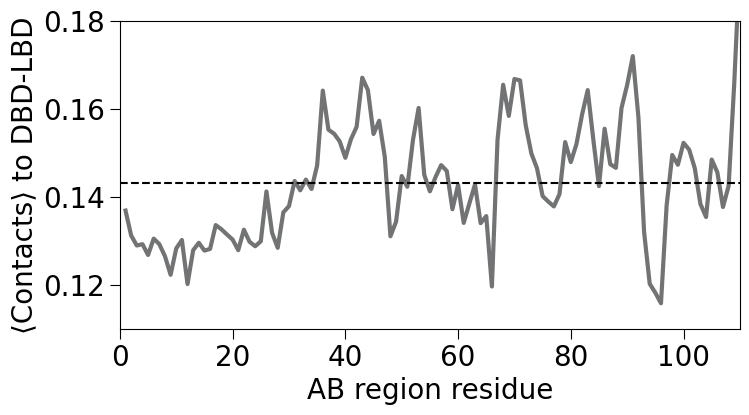

In [35]:
fig = plt.figure(figsize=(8,4))

plt.plot((AB_resis+1)[0:110], contacts_avg_rew[0:110], '-', lw=3, alpha=1.0, label='After rew.', c=colors[2])
plt.axhline(np.average(contacts_avg_rew[0:110]), ls='--', c='black')

plt.xlabel('AB region residue', fontsize=20)
plt.ylabel('⟨Contacts⟩ to DBD-LBD', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

plt.ylim(0.11,0.18)
plt.xlim(0, 110)

fig.savefig('../figures/contacts_ABresidues_DBDLBD_afterrewonly.pdf', bbox_inches='tight', pad_inches=1, dpi=400)

## Contacts AB sequence (DBD and LBD separate)

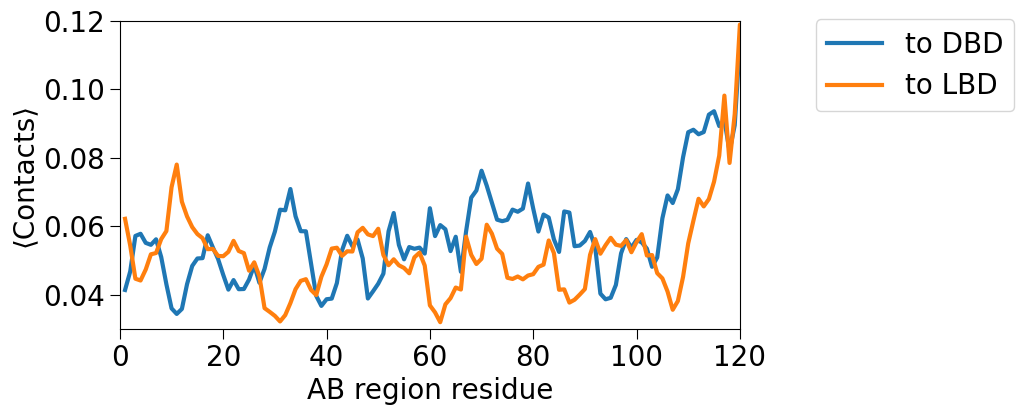

In [36]:
contacts_DBD = load_pickle('../5_analyze_traj/pickles/AB_seq_DBD_contacts_CA.pkl')

contacts_DBD_avg = np.average(contacts_DBD, axis=1)
contacts_DBD_avg_priorrew = np.average(contacts_DBD, axis=1, weights=weights_prior)
contacts_DBD_avg_rew = np.average(contacts_DBD, axis=1, weights=weights)


contacts_LBD = load_pickle('../5_analyze_traj/pickles/AB_seq_LBD_contacts_CA.pkl')

contacts_LBD_avg = np.average(contacts_LBD, axis=1)
contacts_LBD_avg_priorrew = np.average(contacts_LBD, axis=1, weights=weights_prior)
contacts_LBD_avg_rew = np.average(contacts_LBD, axis=1, weights=weights)


fig = plt.figure(figsize=(8,4))

plt.plot(AB_resis+1, contacts_DBD_avg_rew, '-', lw=3, alpha=1.0, label='to DBD')
plt.plot(AB_resis+1, contacts_LBD_avg_rew, '-', lw=3, alpha=1.0, label='to LBD')


plt.xlabel('AB region residue', fontsize=20)
plt.ylabel('⟨Contacts⟩', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

plt.ylim(0.03,0.12)
plt.xlim(0, 120)

plt.legend(fontsize=20, bbox_to_anchor=(1.1, 1.05))

fig.savefig('../figures/contacts_ABresidues_DBDandLBDcomparison.pdf', bbox_inches='tight', pad_inches=1, dpi=400)

## Contacts DBD-LBD sequence

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894491/2616950533.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(DBD_hinge_LBD_resis+1, contacts_avg_priorrew, '-', lw=3, alpha=0.8, label='$\Delta$AB prior', c=colors[1])


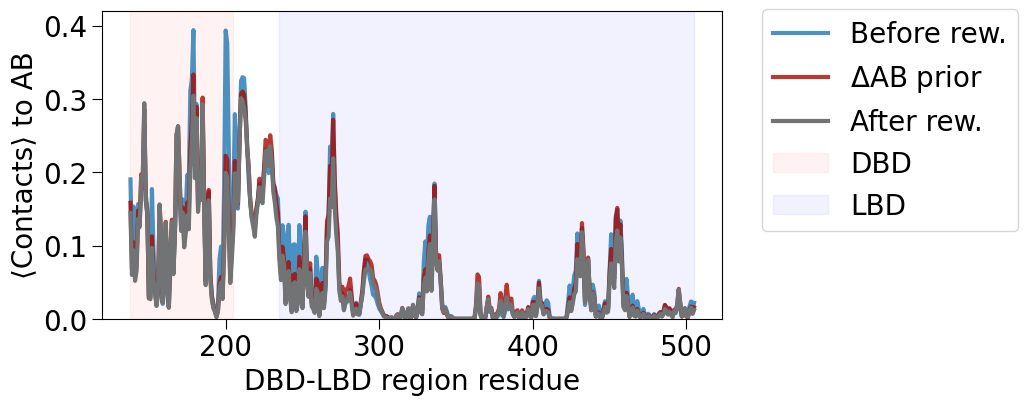

In [37]:
contacts = load_pickle('../5_analyze_traj/pickles/DBD_hinge_LBD_seq_AB_shorter_contacts_CA.pkl')

contacts_avg = np.average(contacts, axis=1)
contacts_avg_priorrew = np.average(contacts, axis=1, weights=weights_prior)
contacts_avg_rew = np.average(contacts, axis=1, weights=weights)

fig = plt.figure(figsize=(8,4))

plt.plot(DBD_hinge_LBD_resis+1, contacts_avg, '-', lw=3, alpha=0.8, label='Before rew.', c=colors[0])
plt.plot(DBD_hinge_LBD_resis+1, contacts_avg_priorrew, '-', lw=3, alpha=0.8, label='$\Delta$AB prior', c=colors[1])
plt.plot(DBD_hinge_LBD_resis+1, contacts_avg_rew, '-', lw=3, alpha=1.0, label='After rew.', c=colors[2])


plt.axvspan((DBD_resis+1)[0], (DBD_resis+1)[-1], ymin=0, ymax=1, alpha=0.05, label='DBD', color='red')
plt.axvspan((LBD_resis+1)[0], (LBD_resis+1)[-1], ymin=0, ymax=1, alpha=0.05, label='LBD', color='blue')


plt.xlabel('DBD-LBD region residue', fontsize=20)
plt.ylabel('⟨Contacts⟩ to AB', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

plt.ylim(0.0,0.42)

plt.legend(fontsize=20, bbox_to_anchor=(1.5, 1.05))

fig.savefig('../figures/DBD_hinge_LBD_seq_AB_shorter_contacts_CA.pdf', bbox_inches='tight', pad_inches=1, dpi=400)

In [38]:
#Make chimeraX attribute file for plotting contacts on structure
with open('../figures/DBD_hinge_LBD_seq_AB_shorter_contacts_avg_rew.defattr', 'w') as f:
    f.write('attribute: AB_contacts\nmatch mode: any\nrecipient: residues\n')
    for resi, avg_contact in zip(DBD_hinge_LBD_resis+1, contacts_avg_rew):
        f.write(f'\t:{resi}\t{avg_contact}\n')

## Contacts LBD sequence only

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2894491/3901583125.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.plot((DBD_hinge_LBD_resis+1)[92:], contacts_avg_priorrew[92:], '-', lw=3, alpha=0.8, label='$\Delta$AB prior', c=colors[1])


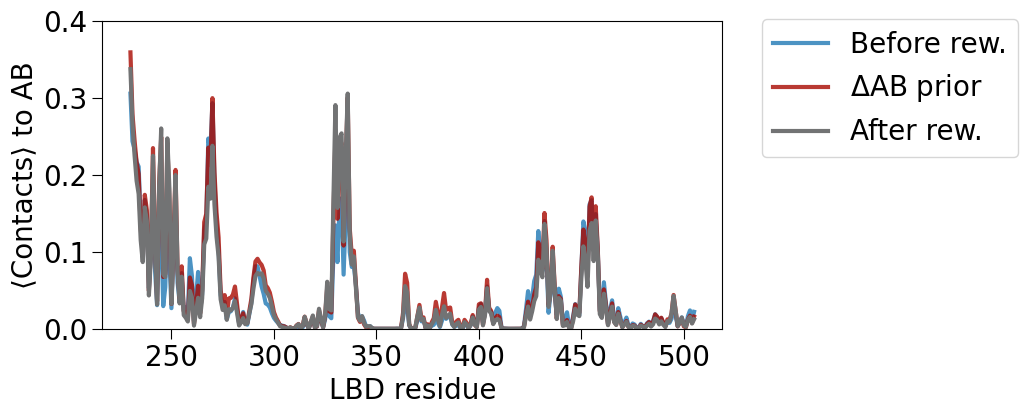

In [39]:
contacts = load_pickle('../5_analyze_traj/pickles/DBD_hinge_LBD_seq_AB_contacts_CA.pkl')

contacts_avg = np.average(contacts, axis=1)
contacts_avg_priorrew = np.average(contacts, axis=1, weights=weights_prior)
contacts_avg_rew = np.average(contacts, axis=1, weights=weights)

fig = plt.figure(figsize=(8,4))

plt.plot((DBD_hinge_LBD_resis+1)[92:], contacts_avg[92:], '-', lw=3, alpha=0.8, label='Before rew.', c=colors[0])
plt.plot((DBD_hinge_LBD_resis+1)[92:], contacts_avg_priorrew[92:], '-', lw=3, alpha=0.8, label='$\Delta$AB prior', c=colors[1])
plt.plot((DBD_hinge_LBD_resis+1)[92:], contacts_avg_rew[92:], '-', lw=3, alpha=1.0, label='After rew.', c=colors[2])

plt.xlabel('LBD residue', fontsize=20)
plt.ylabel('⟨Contacts⟩ to AB', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

plt.ylim(0.0,0.4)

plt.legend(fontsize=20, bbox_to_anchor=(1.5, 1.05))

fig.savefig('../figures/LBD_seq_AB_contacts_CA.pdf', bbox_inches='tight', pad_inches=1, dpi=400)